In [1]:
"""
This scripts runs post-processing steps for Eddy covariance data coming
in one file in the format of europe-fluxdata.eu. This format is very similar
to the ICOS format (the only known difference is the unit of pressure,
which is hPa in europe-fluxdata.eu and kPa in ICOS).

The script covers the following steps:
- spike / outlier detection with mean absolute deviation filter
  after Papale et al. (Biogeosci, 2006)
- ustar filtering after Papale et al. (Biogeosci, 2006)
- carbon flux partitioning with the nighttime method
  of Reichstein et al. (Global Change Biolo, 2005) and
  the daytime method of Lasslop et al. (Global Change Biolo, 2010)
- gap filling with marginal distribution sampling (MDS)
  of Reichstein et al. (Global Change Biolo, 2005)
- flux error estimates using MDS after Lasslop et al. (Biogeosci, 2008)

The script is controlled by a config file in Python's standard configparser
format. The config file includes all possible parameters of used routines.
Default parameter values follow the package REddyProc where appropriate. See
comments in config file for details.

The script currently flags on input all NaN values and given *undefined*
values. Variables should be set to *undefined* in case of other existing flags
before calling the script. Otherwise it should be easy to set the appropriate
flags in the pandas DataFrame dff for the flags after its creation around line
160.

The output file can either have all flagged variables set to *undefined*
and/or can include flag columns for each variable (see config file).

Note, ustar filtering needs at least one full year.

Examples
--------
python postproc_europe-fluxdata.py hesseflux_example.cfg

History
-------
Written, Matthias Cuntz, April 2020
"""

"""

27/09/2021

Integration of Footprint predictor model and satellite images from google earth engine 
to derive empirical remote sensing models and monthly and annual maps.

Written, Mario Alberto Fuentes Monjaraz, October 2021


"""

"""

5/09/2022

Getting code ready  to be used on VLABS

Pdrive: 11204971

"""


'\n\n5/09/2022\n\nGetting code ready  to be used on VLABS\n\nPdrive: 11204971\n\n'

In [2]:
#Intallation of environment via conda
#conda install -c anaconda python=3.6.13
#conda install -c anaconda numpy
#conda install -c anaconda pandas
#pip install hesseflux
#conda install -c conda-forge pyproj
#conda install -c conda-forge earthengine-api
#conda install -c anaconda statsmodels
#conda install -c anaconda scikit-learn
#conda install -c conda-forge folium
#conda install -c conda-forge altair
#conda install -c anaconda ipython

#The code requires Python 3.6 and the next packages
#!pip install numpy
#!pip install pandas
#!pip install hesseflux 
#!pip install pyproj
#!pip install earthengine-api
#!pip install statsmodels
#!pip install sklearn
#!pip install -U scikit-learn
#!pip install folium
#!pip install altair
#!pip install ipython

In [3]:
#Import Python packages used in the code
from __future__ import division, absolute_import, print_function
import time as ptime
import sys
import configparser
import os.path
import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import hesseflux as hf
import altair as alt
import math
from pyproj import Proj
import matplotlib.pyplot as plt
%matplotlib inline
import ee
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import folium
from folium import plugins
from IPython.display import Image
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import pyjams as pj
import time 

In [4]:
#Function to identify columns with specific beggining 
def _findfirststart(starts, names):
    """
    Function that finds variables on the head of a table indicating the name or label of the variable  
    and creates a list of the variables located. The 
    """
    hout = []
    for hh in starts:
        for cc in names:
            if cc.startswith(hh):
                hout.append(cc)
                break
    return hout

#The workflow start here
if __name__ == '__main__':
    t1 = ptime.time()
    
    #*********************************************************************************************************************************************************************
    #1)   Read configuration file
    print('1a)  Opening configuration file')
    
    #1.a) Read from command-line interpreter (It must include in the cosole "GPP.py Configs.cfg" located in the same file)
    #if len(sys.argv) <= 1:
    #raise IOError('Input configuration file must be given.')
    #configfile = sys.argv[1]                                                                          #Change 1. Read configuration (different methods)    
                                                                                                       #For this option a Configs folder is required in the main directory
    #1.b)Read from directory path
    #configfile = 'C:/Users/Administrador/OneDrive/Documentos/MSc Thesis/Configs/DNP_e_shape_configuration.cfg'  
    #configfile = 'C:/Users/Usuario/Documents/Pdrive/Final python codes Anna/Codes/'
    configfile = 'Configs/Configuration_file.cfg'                                                
    
    #1.c)Read from gui window
    #configfile = hf.files_from_gui(initialdir='.', title='configuration file')
    
    config = configparser.ConfigParser(interpolation=None)                                             #Constructor
    config.read(configfile)                                                                            #Read configuration file with the constructor

    #1b) Read file to retrieve file directories and model's marameters 
    print('1b)  Reading configuration file')
    
    # file path
    ID            = config['GENERAL'].get('ID',  ".")
    inputdir      = config['GENERAL'].get('inputdir',  ".")                                            #Change 2. Add inputdir to read folder from Data folder
    outputdir     = config['GENERAL'].get('outputdir', ".")
    
    # meteorological data
    meteo_file    = config['METHEO'].get('meteo_file', ".")
    
    # program switches                                                                                 #Activates each module of the workflow)
    #------------------------------------------------------------
    outlier   = config['POSTSWITCH'].getboolean('outlier',   True)
    ustar     = config['POSTSWITCH'].getboolean('ustar',     True)
    ustar_non_annual  = config['POSTSWITCH'].getboolean('ustar_non_annual',     True)                  #Change 3. Add method ustar_non_annual  to compute the u* filter with a given threshold.
    partition = config['POSTSWITCH'].getboolean('partition', True)                                     #ustar_non_annual  method has to be used instead of ustar when there is not data 
    fill      = config['POSTSWITCH'].getboolean('fill',      True)                                     #for a full date to calculate automatically a threshold
    fluxerr   = config['POSTSWITCH'].getboolean('fluxerr',   True)
    #------------------------------------------------------------
    daily_gpp                 =  config['POSTSWITCH'].getboolean('daily_gpp',                   True)  #Change 4. All the modules 
    #------------------------------------------------------------
    climatological_footprint  =  config['POSTSWITCH'].getboolean('climatological_footprint',    True) 
    calculated_ffp            =  config['POSTSWITCH'].getboolean('calculated_ffp',   False)    
    #------------------------------------------------------------
    vegetation_indices        =  config['POSTSWITCH'].getboolean('vegetation_indices',          True)
    #------------------------------------------------------------
    environmental_variables_station     =  config['POSTSWITCH'].getboolean('environmental_variables_station',           True)
    environmental_variables_satellite   =  config['POSTSWITCH'].getboolean('environmental_variables_satellite',         True)
    tower_observations                  =  config['POSTSWITCH'].getboolean('tower_observations',                        True)
    rei_gpp_switch                      =  config['POSTSWITCH'].getboolean('rei_gpp_switch ',                           True)
    fal_gpp_switch                      =  config['POSTSWITCH'].getboolean('fal_gpp_switch ',                           False)
    las_gpp_switch                      =  config['POSTSWITCH'].getboolean('las_gpp_switch ',                           False)
    
    df_rainfall_station_switch = config['POSTSWITCH'].getboolean('df_rainfall_station_switch',      True)
    df_meteo_station_switch    = config['POSTSWITCH'].getboolean('df_meteo_station_switch',         True)
    df_rainfall_CHIRPS_switch  = config['POSTSWITCH'].getboolean('df_rainfall_CHIRPS_switch',       True)
    df_temp_MODIS_switch       = config['POSTSWITCH'].getboolean('df_temp_MODIS_switch',            True)
    df_meteo_tower_switch      = config['POSTSWITCH'].getboolean('df_meteo_tower_switch',           True)
    
    #------------------------------------------------------------
    correlation_analysis        =  config['POSTSWITCH'].getboolean('correlation_analysis',          True)
    correlation_analysis_simple =  config['POSTSWITCH'].getboolean('correlation_analysis',          True)
    calibration_validation      =  config['POSTSWITCH'].getboolean('calibration_validation',        True) 
    MODIS_analysis              =  config['POSTSWITCH'].getboolean('MODIS_analysis',                True) 
    #------------------------------------------------------------
    timeseries_thirty           =  config['POSTSWITCH'].getboolean('timeseries_thirty',        True) 
    timeseries_fifteen          =  config['POSTSWITCH'].getboolean('timeseries_fifteen',       True) 
    mapping_GPP                 =  config['POSTSWITCH'].getboolean('mapping_GPP',              True)
    classification_maps         =  config['POSTSWITCH'].getboolean('classification_maps',      True)
    maps_from_features          =  config['POSTSWITCH'].getboolean('maps_from_features',       True)
    mapping_GPP_thirty          =  config['POSTSWITCH'].getboolean('mapping_GPP_thirty',       True)
    mapping_GPP_fifteen         =  config['POSTSWITCH'].getboolean('mapping_GPP_fifteen',      True)
    export_maps_to_drive        =  config['POSTSWITCH'].getboolean('export_maps_to_drive',    False) 
    
    # input file format
    eufluxfile  = config['POSTIO'].get('eufluxfile',  '')
    timeformat  = config['POSTIO'].get('timeformat', '%Y%m%d%H%M')
    sep         = config['POSTIO'].get('sep',        ',')
    skiprows    = config['POSTIO'].get('skiprows',   '')
    undef       = config['POSTIO'].getfloat('undef', -9999.)
    swthr       = config['POSTIO'].getfloat('swthr', 10.)
    outputfile  = config['POSTIO'].get('outputfile'  '')
    outputname  = config['POSTIO'].get('outputname'  '')
    outundef       = config['POSTIO'].getboolean('outundef',    False)
    outflagcols    = config['POSTIO'].getboolean('outflagcols', False)

    # input file variables 
    carbonflux     = config['POSTVAR'].get('carbonflux',        'FC')                                  #Change 4. Add variable to identify the name of the carbon fluxes to compute 
                                                                                                       #Carbon flux name to process in the code (e.g. NEE, FC, FC_1)                                                                                              #This change can be done for all the column names of the input file 
    # remove information on a variable 
    remove_SW_IN   = config['POSTVAR'].getboolean('remove_SW_IN', False)                               #remove_SW_IN is only useful for DNP where the SW data was not 
                                                                                                       #for the year of analysis.
    # mad parameters
    nscan = config['POSTMAD'].getint('nscan', 15)
    nfill = config['POSTMAD'].getint('nfill',  1)
    z     = config['POSTMAD'].getfloat('z',    7)
    deriv = config['POSTMAD'].getint('deriv',  2)
    
    # ustar parameters
    ustarmin       = config['POSTUSTAR'].getfloat('ustarmin',    0.1)
    nboot          = config['POSTUSTAR'].getint('nboot',         1)
    plateaucrit    = config['POSTUSTAR'].getfloat('plateaucrit', 0.95)
    seasonout      = config['POSTUSTAR'].getboolean('seasonout', False)                                #Change 5. Add these parameters in the configuration file                      
    applyustarflag = config['POSTUSTAR'].getboolean('applyustarflag', True)

    # gap-filling parameters
    sw_dev  = config['POSTGAP'].getfloat('sw_dev',  50.)
    ta_dev  = config['POSTGAP'].getfloat('ta_dev',  2.5)
    vpd_dev = config['POSTGAP'].getfloat('vpd_dev', 5.0)
    longgap = config['POSTGAP'].getint('longgap',   60)
    
    # partitioning parameters 
    nogppnight = config['POSTPARTITION'].getboolean('nogppnight', False)
    
    # daily gpp computation parameters
    carbonfluxlimit  = config['DAILYGPP'].getint('carbonfluxlimit',         100)                       #Maximun daily GPP (Look in the literature)
    respirationlimit = config['DAILYGPP'].getint('respirationlimit',        100)                       #Minimun daily respiration (Look in the literature)
    rolling_window_gpp   = config['DAILYGPP'].getint('rolling_window_gpp',    3)
    rolling_center_gpp   = config['DAILYGPP'].getboolean('rolling_center_gpp', True)
    rolling_min_periods  = config['DAILYGPP'].getint('rolling_min_periods',    1)
    
    # climatological footprint parameters
    altitude                        = config['CLIMATOLOGICAL'].getfloat('altitude',                      '')                                
    latitude                        = config['CLIMATOLOGICAL'].getfloat('latitude',                      '')                        
    longitude                       = config['CLIMATOLOGICAL'].getfloat('longitude',                     '')                        
    canopy_height                   = config['CLIMATOLOGICAL'].getfloat('canopy_height ',                '')                           
    displacement_height             = config['CLIMATOLOGICAL'].getfloat('displacement_height',           '')                          
    roughness_lenght                = config['CLIMATOLOGICAL'].getfloat('roughness_lenght ',             '')                           
    instrument_height_anenometer    = config['CLIMATOLOGICAL'].getfloat('instrument_height_anenometer',  '')
    instrument_height_gas_analyzer  = config['CLIMATOLOGICAL'].getfloat('instrument_height_gas_analyzer','')
    
    domaint_var  = config['CLIMATOLOGICAL'].get('domaint_var','-2000,2000.,-2000.,2000.').split(',')
    nxt_var      = config['CLIMATOLOGICAL'].get('nxt_var',                        '1000').split(',')
    rst_var      = config['CLIMATOLOGICAL'].get('rst_var',             '20.,40.,60.,80.').split(',')
    for i in range(0, len(domaint_var)):
        domaint_var[i] = float(domaint_var[i])
    for i in range(0, len(rst_var)):
        rst_var[i] = float(rst_var[i])
    
    projection_site_UTM_zone        = config['CLIMATOLOGICAL'].get('projection_site_UTM_zone', '')          #Change 5.1 Projection of climatological footprint
    #projection_site                 = '+proj=utm +zone='+projection_site_UTM_zone+' +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'       
    projection_site                 = '+proj=utm +zone='+projection_site_UTM_zone+' +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'       
    boundary_layer_height           = config['CLIMATOLOGICAL'].getfloat('boundary_layer_height',     '1500')
    
    # vegetation indices parameters 
    max_cloud_coverage              = config['VI'].getint('max_cloud_coverage',         100)                 #Default: No filter, all images available.
    crs                             = config['VI'].get('crs',                            '')                 #EPSG:4326
    ndviMask                        = config['VI'].getfloat('ndviMask',                -100)                 #Default: No mask
    mndviMask                       = config['VI'].getfloat('mndviMask',               -100)                 #Default: No mask
 
    # environmental vegetation parameters
    rolling_window_ev_meteo         = config['EV'].getint('rolling_window_ev_meteo',            3)
    rolling_window_ev_meteo_sat     = config['EV'].getint('rolling_window_ev_meteo_sat',        3)
    rolling_window_gpp_MODIS        = config['EV'].getint('rolling_window_gpp_MODIS',           3)
    precipitation_data              = config['EV'].get('precipitation_data',                   '').split(',')
    
    # mapping parameters
    feature_collection              = config['MAPS'].get('feature_collection',                 '')   
    ecosystem_extension             = config['MAPS'].getint('ecosystem_extension ',          5000) 
    number_clusters                 = config['MAPS'].getint('number_clusters ',                 4) 


1a)  Opening configuration file
1b)  Reading configuration file


In [5]:
    #*********************************************************************************************************************************************************************
    #2)   Setting data frames
    print('2)   Formatting data frames')
    t01 = ptime.time()
    
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #2.a)   Read eddy covariance files (eufluxfiles)
    print('      Read data: ', eufluxfile)
    
    # Assert iterable                                                                                  #This process reads the names of the eufluxfiles and adds the directory information. The loop allows to introduce n number of files for different years
    if ',' in eufluxfile:
        eufluxfile     = eufluxfile.split(',')
        
        eufluxfile     = [ inputdir  + ee.strip() for ee in eufluxfile ]                               #Change 6. Add inputdir                                                                                 
    else:                                                                                              #If the inputdir  is not added in this section, the input file need to be in the main directory and not in the inputdir file          
        if eufluxfile:                                                                                   
            eufluxfile = [inputdir  + eufluxfile]
        else:
            try:
                eufluxfile = hf.files_from_gui(                                                        #If any direction to the files is given, the files has to be selected through a pup up window
                    initialdir='.', title='europe-fluxdata.eu file(s)')
            except:
                raise IOError("GUI for europe-fluxdata.eu file(s) failed.")
                
    # Identify rows in the dataframe to skipt              
    if skiprows == 'None':                                                                             #This process allows to identify the rows to skipt in the data frames
        skiprows = ''
    if skiprows:
        import json  # to analyse int or list, tuple not working
        skiprows = json.loads(skiprows.replace('(', '[').replace(')', ']'))
        
    # Read input files into Panda data frame and check variable availability
    parser = lambda date: dt.datetime.strptime(date, timeformat)                               

    infile = eufluxfile[0]                                                                             #Loads the first file in the eufluxfile list                                                                                          
    df = pd.read_csv(infile, sep, skiprows=skiprows, parse_dates=[0], 
                     date_parser=parser, index_col=0, header=0)
    if len(eufluxfile) > 1:                                                                            #Iterate to integrate all the files in case of data for different years is available 
        for infile in eufluxfile[1:]:                    
            df_aux_a = pd.read_csv(infile, sep, skiprows=skiprows, parse_dates=[0],
                              date_parser=parser, index_col=0, header=0)
            df       = df.append(df_aux_a, sort=False)
            
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 
    # Process to ensure constant 30-minute frequency in the datasets
    # identify beggining and end of the time series
    df_time_aux = df.copy()
    df_time_aux = df_time_aux.reset_index()
    time1_aux   = df_time_aux.iloc[0, 0]
    time2_aux   = df_time_aux.iloc[df.shape[0] -1,0]
    
    # create time series with daily frequency (Not needed if usinf gap filled variables)
    time_series_aux = pd.date_range(time1_aux, time2_aux, freq="30min")
    time_series_aux = pd.DataFrame(time_series_aux).rename(columns={0: 'TIMESTAMP_START'})
    time_series_aux ['TIMESTAMP_END']   = time_series_aux['TIMESTAMP_START'] + dt.timedelta(minutes = 30)
    time_series_aux.set_index('TIMESTAMP_START',inplace=True)
    df_time_aux.set_index('TIMESTAMP_START',inplace=True)
    df_time_aux.drop('TIMESTAMP_END', axis =1, inplace=True)
    df_time_aux_final = pd.merge(left= time_series_aux, right = df_time_aux,
                     how="left", left_index = True , right_index = True)
    df_time_aux_final.replace(np.nan, undef, inplace=True)
    df = df_time_aux_final.copy(deep=True)
    
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
    #2.b)   Formatting the input file    
    print('      Formating data: ', eufluxfile)
    
    # Fill the undef values (e.g. -9999.) with null values (NaN)
    #df.fillna(undef, inplace=True)
        
    # Flag.                                                                                            #Create file with flags
    dff              = df.copy(deep=True)
    dff[:]           = 0
    dff[df == undef] = 2                                                                               #(Flag 2) for null values
    #dff[df.isna()]   = 2
    
    # day / night
    #isday = df['SW_IN'] > swthr                                                                       #This column in the data frame indicates the short wave radiation which
    hsw = ['SW_IN']                                                                                    #can be use to identify difference between day an night. Threshold is set in the configuration file
    hout = _findfirststart(hsw, df.columns)                                                            #Change 7. Use _findfirststart method to look for the SW_IN column
    isday = df[hout[0]] >= swthr
    
    if remove_SW_IN:                                                                                   # Remove 'SW_IN' data from the data frame to not be used in the GPP flux partitioning in case the data is not available.  
        df['SW_IN']=-9999.                                                                             #Change 7.1 Remove SW_IN. This change is just relevant for the study case of Doñana
        df['SW_IN'].replace(-9999., np.nan, inplace=True) 
        
    # Check Ta in Kelvin
    hta = ['TA']                                                                                       #Change 8. Change TA_ for TA. Allows more flexibility in the column names of the input file
    hout = _findfirststart(hta, df.columns)                                                            #This process identifies if the temperature is in kelvin or in celcious                                                
    if df[hout[0]].max() < 100.:
        tkelvin = 273.15
    else:
        tkelvin = 0.
        
    # Add tkelvin only where not flagged
    df.loc[dff[hout[0]] == 0, hout[0]] += tkelvin

    # Add vpd if not given
    hvpd = ['VPD']
    hout = _findfirststart(hvpd, df.columns)
    if len(hout) == 0:
        hvpd = ['TA', 'RH']                                                                            #Change 9. Change TA_ and RH_ for TA and RH                                                                               
        hout = _findfirststart(hvpd, df.columns)
        if len(hout) != 2:
            raise ValueError('Cannot calculate VPD.')
        ta_id = hout[0]
        rh_id = hout[1]
        if df[ta_id].max() < 100.:
            tk = df[ta_id] + 273.15
        else:
            tk = df[ta_id]
        if df[rh_id].max() > 10.:
            rh = df[rh_id] / 100.
        else:
            rh = df[rh_id]
        list_1    = 1. - rh
        list_2    =  pj.esat(tk)
        list_1_df = list_1.to_frame().reset_index()
        list_2_df = list_2.to_frame().rename(columns={0: 'TK'})
        list_1_df['VPD_Total'] = list_1_df['RH'] * list_2_df['TK']
        list_final = list_1_df.set_index('TIMESTAMP_START')
        vpd_id = 'VPD'
        df[vpd_id] = list_final['VPD_Total']
        df[vpd_id].where((df[ta_id] != undef) | (df[rh_id] != undef),
                         other=undef, inplace=True)
        dff[vpd_id] = np.where((dff[ta_id] + dff[rh_id]) > 0, 2, 0)                                    #(Flag 2) in 'VPD_CALC'  where ta or rh is not available
        df.loc[dff[vpd_id] == 0, vpd_id] /= 100.                                                       #Converts from hPa to Pa 

    # Check VPD in Pa
    hvpd = ['VPD']
    hout = _findfirststart(hvpd, df.columns)
    if df[hout[0]].max() < 10.:     # kPa
        vpdpa = 1000.
    elif df[hout[0]].max() < 100.:  # hPa
        vpdpa = 100.
    else:
        vpdpa = 1.                  # Pa
    df.loc[dff[hout[0]] == 0, hout[0]] *= vpdpa  
    
    # Time stepping                                                                                    #Derives the number of datapoints per day
    dsec  = (df.index[1] - df.index[0]).seconds
    ntday = np.rint(86400 / dsec).astype(np.int)                                                       #Indicates the number of records per day
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    t02   = ptime.time()                                                                               #Change 9. Change legend of computation time
    strin = ( '{:.1f} [minutes]'.format((t02 - t01) / 60.)                                           
              if (t02 - t01) > 60.
              else '{:d} [seconds]'.format(int(t02 - t01))
            )
    print('     Computation setting data frames in ', strin , end='\n')    
    
    #********************************************************************************************************************************************************************* 
    # 3)   Outlier detection
    if outlier:
        print('3)   Spike detection')
        t11 = ptime.time()

        # Finds carbon flux data (e.g. NEE or FC)
        houtlier = [carbonflux]                                                                        #Change 10. Process only the carbonflux variable (H and LE could be processed in the same way)                                            
        hout = _findfirststart(houtlier, df.columns)
        print('      Using:', hout)
        
        # Applies the spike detection. Only one call to mad for all variables                          #carbonflux variable can be a list with NEE, H, LE, etc. and the .madspike() requires to be called only once for alll the variables
        sflag = hf.madspikes(df[hout], flag=dff[hout], isday=isday,                                    #This function creates flags with value 2 for outliers that are translated to flags 3 in the dff file
                             undef=undef, nscan=nscan * ntday,                                 
                             nfill=nfill * ntday, z=z, deriv=deriv, plot=False)
        
        for ii, hh in enumerate(hout):
            dff.loc[sflag[hh] == 2, hh]   = 3                                                          #(Flag 3) for outlieres. The tool flags outliers even when there are emptyspaces
            #dff.loc[df[hh] == undef , hh] = 2                                                         #It cannot assign flag 3 if there was not data available in the carbonflux data. It is a correction of the flag                                                        

        t12   = ptime.time()                                                                           #Change 11. Change legend of computation time  
        strin = ( '{:.1f} [minutes]'.format((t12 - t11) / 60.)                                                
                  if (t12 - t11) > 60.
                  else '{:d} [seconds]'.format(int(t12 - t11))
                )
        print('     Computation outlier detection in ', strin)  
        
    #********************************************************************************************************************************************************************* 
    # 4) u* filtering (data for a full year)
    if  ustar:                                                                                         #This method requires a data set with data for a full year
        print('4)   u* filtering')
        t21 = ptime.time()
        
        #Looking for carbonflux, u*, and temperature data
        hfilt = [carbonflux, 'USTAR', 'TA']                                                            #Change 12. Change 'NEE' for carbonflux variable
        hout  = _findfirststart(hfilt, df.columns)
    
        assert len(hout) == 3, 'Could not find CO2 flux (NEE or FC), USTAR or TA in input file.'
        print('      Using:', hout)
        
        #Saves a copy of the flags of the carbonflux data
        ffsave = dff[hout[0]].to_numpy()
        
        #Sets a temporal flag 
        #iic    = np.where((~isday) & (df[hout[0]] < 0.))[0] 
        #dff.iloc[iic, list(df.columns).index(hout[0])] = 4                                            #(Flag 4). Temporal flag for data with negative values in the carbon fluxes during night
                                                                                                       #Assigns flag 4 for cases of GPP negative during night time.
        dff.loc[(~isday) & (df[hout[0]] < 0.), hout[0]] = 4 
        # Applies the u* filtering
        #ustars, flag = hf.ustarfilter(df[hout], flag=dff[hout],                                       #Check method to identify why the temporal flag is required in the ustarfilter
        #                              isday=isday, undef=undef,                                       #ustarfilter function creates flags with value 2 for outliers that are translated to flags 3 in the dff file                 
        #                              ustarmin=ustarmin, nboot=nboot,
        #                              plateaucrit=plateaucrit,
        #                              seasonout=seasonout,
        #                              plot=False)
        
        ustars, flag = hf.ustarfilter(df[hout], flag=dff[hout],
                                      isday=isday, undef=undef,
                                      ustarmin=ustarmin, nboot=nboot,
                                      plateaucrit=plateaucrit,
                                      seasonout=False, plot=False)
        
        dff[hout[0]] = ffsave                                                                          #Return to original flags file without 4-flag
        df  = df.assign(USTAR_TEST=flag)                                                               #Change 14. Change 'USTAR_TEST_1_1_1' column name for 'USTAR_TEST'                                                                
        dff = dff.assign(USTAR_TEST=np.zeros(df.shape[0], dtype=np.int))                               #This line adds a column in the dataframe of flags 
        
        if applyustarflag:
            hustar = [carbonflux]                                                                      #Change 15. Process only the carbonflux variable (H and LE could be processed in the same way)   
            hout = _findfirststart(hustar, df.columns)
            print('      Using:', hout)
            for ii, hh in enumerate(hout):
                dff.loc[flag [hh] == 2, hh] = 5                                                        #(Flag 5) for carbon fluxes with ustar(friction velocity) below calculated threshold
                #dff.loc[df[hh] == undef, hh] = 2                                  
                
        t22   = ptime.time()                                                                           #Change 16. Change legend of computation time.
        strin = ( '{:.1f} [minutes]'.format((t22 - t21) / 60.)                                           
                  if (t22 - t21) > 60.
                  else '{:d} [seconds]'.format(int(t22 - t21))
                )
        print('     Computation u* filtering detection in ', strin) 

    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # 4)   u* filtering (data for partial year)
    if  ustar_non_annual :                                                                             #Change 17. ustar_non_annual  is a copy of ustar without the 'ustarfilter'
        print('4)   u* filtering (less than 1-year data)')                                             #The ustar_noN_annual method is simple approach to manually set a ustar threshold when 
        t21 = ptime.time()                                                                             #there is no data for a full year required to compute ustar
        
        #Looking for carbonflux, u*, and temperature data
        hfilt = [carbonflux, 'USTAR', 'TA']                                                            
        hout  = _findfirststart(hfilt, df.columns)
        assert len(hout) == 3, 'Could not find CO2 flux (NEE or FC), USTAR or TA in input file.'
        print('      Using:', hout)
        
        flag = sflag.copy().multiply(0)
        
        #flag.loc[(df['USTAR'] < ustarmin) & (dff[carbonflux] == 2), carbonflux] = 2.
        #flag.loc[(df['USTAR'] < ustarmin) & (dff[carbonflux] == 3), carbonflux] = 2.
        #flag.loc[(df['USTAR'] < ustarmin), carbonflux] = 2.
        #flag.loc[(df['USTAR'] < ustarmin) & (dff['USTAR'] != 2) & (dff[carbonflux] != 2), carbonflux] = 2.
        #Flags when the USTAR is below ustarmin and when there is carbonflux data available for the same timestep. 
        flag.loc[(df['USTAR'] < ustarmin) & (df[carbonflux] != undef), carbonflux] = 2.
        #flag.loc[(df['USTAR'] < ustarmin), carbonflux] = 2.
                               
        df  = df.assign(USTAR_TEST=flag)               
        dff = dff.assign(USTAR_TEST=np.zeros(df.shape[0], dtype=np.int))

        if applyustarflag:
            hustar = [carbonflux]
            hout = _findfirststart(hustar, df.columns)
            print('      Using:', hout)
            for ii, hh in enumerate(hout):
                dff.loc[flag[hh] == 2, hh] = 5 
                #dff.loc[df[hh] == undef, hh] = 2 

        t22   = ptime.time()                                                                           
        strin = ( '{:.1f} [minutes]'.format((t22 - t21) / 60.)                                           
                  if (t22 - t21) > 60.
                  else '{:d} [seconds]'.format(int(t22 - t21))
                )
        print('     Computation u* filtering detection in ', strin) 

    #********************************************************************************************************************************************************************* 
    # 5)   Flux partitioning
    if partition:
        print('5)   Flux partitioning')
        t31 = ptime.time()
        
        #Looking for carbon flux, global radiation, temperature and vpd data
        hpart = [carbonflux, 'SW_IN', 'TA', 'VPD']                                                     #Change 18. Change 'NEE' for carbonflux variable                                                                      
        hout  = _findfirststart(hpart, df.columns)
        assert len(hout) == 4, 'Could not find CO2 flux (NEE or FC), SW_IN, TA, or VPD in input file.'
        print('      Using:', hout)

        suff = hout[0]                                                                                 #Change 20. Rename with the carbonflux variable              
 
        # nighttime method
        print('      Nighttime partitioning')
        dfpartn = hf.nee2gpp(df[hout], flag=dff[hout], isday=isday,
                             undef=undef, method='reichstein',
                             nogppnight=nogppnight)

        dfpartn.rename(columns=lambda c: c + '_' + suff + '_rei', inplace=True)                        #Change 21. Add '_' before suff and change '1' with '_1'
            
        # falge method                                                                                 #Change 22. Falge method instead of lasslop method
        print('      Falge method')
        dfpartf = hf.nee2gpp(df[hout], flag=dff[hout], isday=isday,
                             undef=undef, method='falge',         
                             nogppnight=nogppnight)  
        
        dfpartf.rename(columns=lambda c: c + '_' + suff + '_fal', inplace=True)
        
        # daytime method                                                                               #Change 23. Day time method 'lasslop' can be integrated as a third method
        print('      Daytime partitioning')
        dfpartd = hf.nee2gpp(df[hout], flag=dff[hout], isday=isday,
                             undef=undef, method='lasslop',
                             nogppnight=nogppnight)
        
        dfpartd.rename(columns=lambda c: c  + '_' + suff + '_las', inplace=True) 

        df = pd.concat([df, dfpartn, dfpartf, dfpartd],  axis=1)

        # take flags from NEE or FC same flag
        for dn in ['rei', 'fal', 'las']:
            for gg in ['GPP', 'RECO']:                                                                 #Change 24. Adds '_' between labels
                dff[gg + '_' + suff + '_'+ dn] = dff[hout[0]]                                          #Takes flags from the carbonflux variable
                
        # flag GPP and RECO if they were not calculated
        for dn in ['rei', 'fal', 'las']:
            for gg in ['GPP', 'RECO']:                                                                 #Change 25. This method flags with 2 value the 'RECO' columns when 'GPP was not calculated
                dff.loc[df['GPP' + '_' + suff + '_'+ dn] == undef, gg + '_' + suff + '_'+ dn ] = 2     #('GPP' == undef)
          
        t32   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t32 - t31) / 60.)                                         #Change 26. Change legend of computation time.         
                  if (t32 - t31) > 60.
                  else '{:d} [seconds]'.format(int(t32 - t31))
                )
        print('     Computation flux partitioning detection in ', strin)  
        
    #********************************************************************************************************************************************************************* 
    # 6)   Gap-filling
    if fill:        
        print('6)   Gap-filling')
        t41 = ptime.time()
        
        #Looking for meteorological data
        hfill = ['SW_IN', 'TA', 'VPD']
        hout  = _findfirststart(hfill, df.columns)
        assert len(hout) == 3, 'Could not find SW_IN, TA or VPD in input file.'

        # if available
        rei_gpp = 'GPP_'+carbonflux+'_rei'
        rei_res = 'RECO_'+carbonflux+'_rei'
        fal_gpp = 'GPP_'+carbonflux+'_fal'
        fal_res = 'RECO_'+carbonflux+'_fal'
        las_gpp = 'GPP_'+carbonflux+'_las'
        las_res = 'RECO_'+carbonflux+'_las'
        
        hfill = [ carbonflux,                                                                          #Change 27. Change names of columns to process
                  rei_gpp,rei_res,fal_gpp,fal_res,las_gpp,las_res,
                  'SW_IN', 'TA', 'VPD']
        
        hout  = _findfirststart(hfill, df.columns)
        print('      Using:', hout)
        
        df_f, dff_f = hf.gapfill(df[hout], flag=dff[hout],
                                 sw_dev=sw_dev, ta_dev=ta_dev, vpd_dev=vpd_dev,
                                 longgap=longgap, undef=undef, err=False,
                                 verbose=1)
        
        #hdrop = ['SW_IN', 'TA', 'VPD']                           
        #hout = _findfirststart(hdrop, df.columns)
        #df_f.drop(columns=hout,  inplace=True)
        #dff_f.drop(columns=hout, inplace=True)

        def _add_f(c):
            return '_'.join(c.split('_')[:-3] + c.split('_')[-3:]  + ['f'])                            #Change 28. 'f' of fill till the end of the name of the column names
        df_f.rename(columns=_add_f,  inplace=True)
        dff_f.rename(columns=_add_f, inplace=True)    
        
        df  = pd.concat([df,  df_f],  axis=1)
        dff = pd.concat([dff, dff_f], axis=1)
        
        t42   = ptime.time()                                                                           #Change 29. Change legend of computation time.
        strin = ( '{:.1f} [minutes]'.format((t42 - t41) / 60.)                                           
                  if (t42 - t41) > 60.
                  else '{:d} [seconds]'.format(int(t42 - t41))
                )
        print('     Computation filling gaps detection in ', strin) 
        
    #********************************************************************************************************************************************************************* 
    # 7)   Error estimate
    if fluxerr:
        print('7)   Flux error estimates')
        t51 = ptime.time()
        
        #Looking for meteorological data
        hfill = ['SW_IN', 'TA', 'VPD']
        hout  = _findfirststart(hfill, df.columns)
        assert len(hout) == 3, 'Could not find SW_IN, TA or VPD in input file.'

        # if available 
        rei_gpp = 'GPP_'+carbonflux+'_rei'
        rei_res = 'RECO_'+carbonflux+'_rei'
        fal_gpp = 'GPP_'+carbonflux+'_fal'
        fal_res = 'RECO_'+carbonflux+'_fal'
        las_gpp = 'GPP_'+carbonflux+'_las'
        las_res = 'RECO_'+carbonflux+'_las'
        
        hfill = [ carbonflux,                                                                          #Change 30. Change names of columns to process
                  rei_gpp,rei_res,fal_gpp,fal_res,las_gpp,las_res,
                  'SW_IN', 'TA', 'VPD']
        
        hout  = _findfirststart(hfill, df.columns)
        print('      Using:', hout)
        
        df_e = hf.gapfill(df[hout], flag=dff[hout],
                          sw_dev=sw_dev, ta_dev=ta_dev, vpd_dev=vpd_dev,
                          longgap=longgap, undef=undef, err=True, 
                          verbose=1)
        
        hdrop = ['SW_IN', 'TA', 'VPD']
        hout = _findfirststart(hdrop, df.columns)
        df_e.drop(columns=hout, inplace=True)

        def _add_e(c):                                                                                 #Change 31. Create _add_e instead of reusing _add_f
            return '_'.join(c.split('_')[:-3] + c.split('_')[-3:] + ['e'])

        # rename the variables with e (error)
        colin  = list(df_f.columns)
        df_e.rename(columns=_add_e,  inplace=True)
        colout = list(df_f.columns)                                                                    #List with updated names to display in the dff file
        df     = pd.concat([df, df_f], axis=1)
        
        # take flags of non-error columns with the same label
        for cc in range(len(colin)):
            dff[colout[cc]] = dff[colin[cc]]

        t52   = ptime.time()                                                                           #Change 32. Change legend of computation time.
        strin = ( '{:.1f} [minutes]'.format((t52 - t51) / 60.)                                           
                  if (t52 - t51) > 60.
                  else '{:d} [seconds]'.format(int(t52 - t51))
                )
        print('     Computation flux error estimates in ', strin) 

    #********************************************************************************************************************************************************************* 
    # 8)   Output
    print('8)   Outputfile')
    t61 = ptime.time()

    if not outputfile:
        try:
            outputdir = hf.directory_from_gui(initialdir='.',
                                              title='Output directory')
        except:
            raise IOError("GUI for output directory failed.")
            
        outputfile = configfile[:configfile.rfind('.')]                                                #Takes the name from the configurtion file
        outputfile = outputdir + '/' + ID + '_' + os.path.basename(outputfile + '.csv')                           #Change 33. Change outdir for outputdir to select directly the output folder
    else:
        outputfile = outputdir +  outputfile + ID + '_' +  outputname                                                    #Change 34. Create outputfile in case outputfile and outputdir are available 
        
    print('      Write output ', outputfile)

    # Back to original units
    hta = ['TA']
    hout = _findfirststart(hta, df.columns)
    df.loc[dff[hout[0]] == 0, hout[0]] -= tkelvin
    hvpd = ['VPD']
    hout = _findfirststart(hvpd, df.columns)
    df.loc[dff[hout[0]] == 0, hout[0]] /= vpdpa

    if outundef:
        print('      Set flags to undef.')
        for cc in df.columns:
            if cc.split('_')[-1] != 'f' and cc.split('_')[-1] != 'e':  # exclude gap-filled columns    #Change 35. Change [-4] for [-1] and exclude error 'e' columns
                df[cc].where(dff[cc] == 0, other=undef, inplace=True)  # Is the & working?             #This line writes undef (-9999.) for all the flagged data

    if outflagcols:
        print('      Add flag columns.')

        def _add_flag(c):
            return 'flag_' + c
        dff.rename(columns=_add_flag, inplace=True)
        
        # no flag columns for flags
        dcol = []
        for hh in dff.columns:
            if '_TEST' in hh:                                                                          #Avoids bringing _TEST data from dff which is an data columnd only with zero values not connected to the datasets                                                                 #Change 36. Change '_TEST_' for '_TEST'
                dcol.append(hh)
        if dcol:
            dff.drop(columns=dcol, inplace=True)                                                       #Remove the TEST columns
        df = pd.concat([df, dff], axis=1)
        
    else:
        print('      Add flag columns for gap-filled variables.')
        occ = []
        for cc in df.columns:
            if cc.split('_')[-1] == 'f' or cc.split('_')[-1] == 'e':                                   #Change 37. Add the error columns 'e' in the condition
                occ.append(cc)                                                                         #Selects only flags for _f or _e
        dff1 = dff[occ].copy(deep=True)                                                               
        dff1.rename(columns=lambda c: 'flag_' + c, inplace=True)
        df = pd.concat([df, dff1], axis=1)
    
    print('      Write.')
    df.to_csv(outputfile, sep=sep, na_rep=str(undef), index=True,
              date_format=timeformat)
    
    t62   = ptime.time()
    strin = ( '{:.1f} [minutes]'.format((t62 - t61) / 60.)                                             #Change 37. Change legend of computation time.          
              if (t62 - t61) > 60.
              else '{:d} [seconds]'.format(int(t62 - t61))
            )
    print('      Creating output file in ', strin) 
    
    #********************************************************************************************************************************************************************* 
    # Next elements are complement modules to compute Remote Sensing empirical models of GPP           #Change 39. All below code is extra code to derive empirical models
    #*********************************************************************************************************************************************************************
    # 9)   Daily estimations 
    if daily_gpp:                                                                                       
        print('9)   Daily GPP')
        t71 = ptime.time()

        # Daily GPP and enviromental drivers
        gpp = df.copy()
        
        gpp = gpp[(gpp[carbonflux+'_f'] < carbonfluxlimit) & (gpp[carbonflux+'_f'] > -carbonfluxlimit)]                                                           #These parameters are set to avoid having fluxing carboxes beyond specific established limits.
        gpp = gpp[(gpp[rei_res+'_f'] < respirationlimit) & (gpp[rei_res+'_f'] > -respirationlimit)] 
        
        gpp_mean = gpp[['TA_f','VPD_f','SW_IN_f']]
        gpp_sum  = gpp[[carbonflux+'_f',rei_gpp+'_f',rei_res+'_f',fal_gpp+'_f',fal_res+'_f',las_gpp+'_f',las_res+'_f']] * 12 * 30 * 60 /1000000

        gpp_mean = gpp_mean.reset_index()
        gpp_sum  = gpp_sum.reset_index()

        gpp_mean['date']  =  gpp_mean['TIMESTAMP_START'].dt.date
        gpp_sum ['date']  =  gpp_sum['TIMESTAMP_START'].dt.date
        
        gpp_mean.replace(undef, np.nan, inplace=True)
        gpp_sum.replace(undef, np.nan, inplace=True) 

        gpp_mean_daily = gpp_mean.groupby('date').mean()
        gpp_sum_daily  = gpp_sum.groupby('date').sum()

        df_gpp = pd.concat([gpp_mean_daily, gpp_sum_daily], axis=1)

        # identify beggining and end of the time series
        df_time = df_gpp.reset_index()
        time1 = df_time.iloc[0, 0]
        time2 = df_time.iloc[df_gpp.shape[0] -1,0]

        # create time series with daily frequency (Not needed if usinf gap filled variables)
        time_series = pd.date_range(time1, time2, freq="D")
        time_series = pd.DataFrame(time_series).rename(columns={0: 'date'}).set_index('date')
        df_gpp_time = pd.merge(left= time_series, right = df_gpp,
                                 how="left", left_index = True , right_index = True)

        # smoth time series  
        #df_gpp_smoth  = df_gpp_smoth.interpolate(method='akima', order=1, limit_direction ='backward')
        df_gpp_smoth  = df_gpp_time.interpolate(method='akima', order=1, limit_direction ='forward')
        df_gpp_smoth  = df_gpp_smoth.rolling(rolling_window_gpp, center=rolling_center_gpp, min_periods=rolling_min_periods).mean()

        # save file of daily GPP
        df_gpp_smoth.to_csv(outputdir + "/GPP_output/" + ID + "_GPP_daily.csv")

        t72   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t72 - t71) / 60.)                                                      
                  if (t72 - t71) > 60.
                  else '{:d} [seconds]'.format(int(t72 - t71))
                )
        print('     Computed daily GPP in ', strin) 
        
    #********************************************************************************************************************************************************************* 
    # Finish Correction of Data with the Hesseflux package 
    t2   = ptime.time()                                                                                #Change 38. Change legend of computation time.
    strin = ( '{:.1f} [minutes]'.format((t2 - t1) / 60.)                                            
              if (t2 - t1) > 60.
              else '{:d} [seconds]'.format(int(t2 - t1))
            )
    print('Total time of correction of data ', strin) 
    #********************************************************************************************************************************************************************* 

2)   Formatting data frames
      Read data:  \NEE\NEE_data_Germany.txt
      Formating data:  ['Input\\NEE\\NEE_data_Germany.txt']
     Computation setting data frames in  0 [seconds]
3)   Spike detection
      Using: ['NEE']
     Computation outlier detection in  1 [seconds]
4)   u* filtering (less than 1-year data)
      Using: ['NEE', 'USTAR', 'TA']
      Using: ['NEE']
     Computation u* filtering detection in  0 [seconds]
5)   Flux partitioning
      Using: ['NEE', 'SW_IN', 'TA', 'VPD']
      Nighttime partitioning


C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


      Falge method
      Daytime partitioning


C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encou

C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encou

C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\fuentesm\Anaconda3\envs\eShape\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encou

     Computation flux partitioning detection in  11 [seconds]
6)   Gap-filling
      Using: ['NEE', 'GPP_NEE_rei', 'RECO_NEE_rei', 'GPP_NEE_fal', 'RECO_NEE_fal', 'GPP_NEE_las', 'RECO_NEE_las', 'SW_IN', 'TA', 'VPD']
  Filling  NEE
  Filling  GPP_NEE_rei
  Filling  RECO_NEE_rei
  Filling  GPP_NEE_fal
  Filling  RECO_NEE_fal
  Filling  GPP_NEE_las
  Filling  RECO_NEE_las
     Computation filling gaps detection in  2 [seconds]
8)   Outputfile
      Write output  Output\NEE_output\Germany_v0_NEE_corrected_with_flags.csv
      Add flag columns for gap-filled variables.
      Write.
      Creating output file in  1 [seconds]
9)   Daily GPP
     Computed daily GPP in  0 [seconds]
Total time of correction of data  16 [seconds]


# Plot eddy covariance fluxes and GPP

Daily GPP

In [6]:
# print time series
model = '_rei_f'
import altair as alt

data_ec        = df_gpp_smoth.reset_index()
data_co_fluxes = data_ec[['date','GPP_'+carbonflux+ model]].copy()
data_co_fluxes = data_co_fluxes.rename(columns={
    'GPP_'+carbonflux + model: 'GPP (gC m-2 day-1)',
})
data_co_fluxes.head(10)

alt.Chart(data_co_fluxes).mark_bar(size=1).encode(
    x='date:T',
    y='GPP (gC m-2 day-1):Q',
    color=alt.Color(
        'GPP (gC m-2 day-1):Q', scale=alt.Scale(scheme='redyellowgreen', domain=(0, 14))),
    tooltip=[
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('GPP (gC m-2 day-1):Q', title='GPP (gC m-2 day-1)')
    ]).properties(width=600, height=300)

alt.Chart(...)

(-20.0, 20.0)

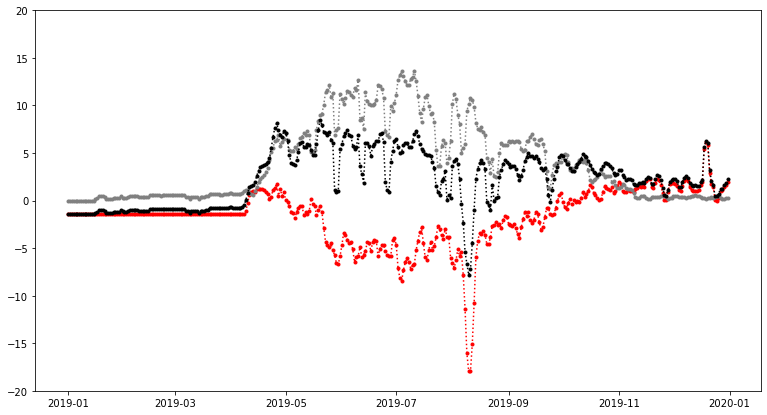

In [7]:
fig, axes=plt.subplots(figsize=(13,7))

axes.plot(df_gpp_smoth[carbonflux+'_f'], marker='.', linestyle=':', ms = 6, color = 'RED', 
             label='Serie original')
axes.plot(df_gpp_smoth[rei_gpp+'_f'], marker='.', linestyle=':', ms = 6, color = 'GRAY', 
             label='Serie original')
axes.plot(df_gpp_smoth[rei_res+'_f'], marker='.', linestyle=':', ms = 6, color = 'BLACK', 
             label='Serie original')

axes.set_ylim(-20, 20)

30-minute filled data

(-50.0, 50.0)

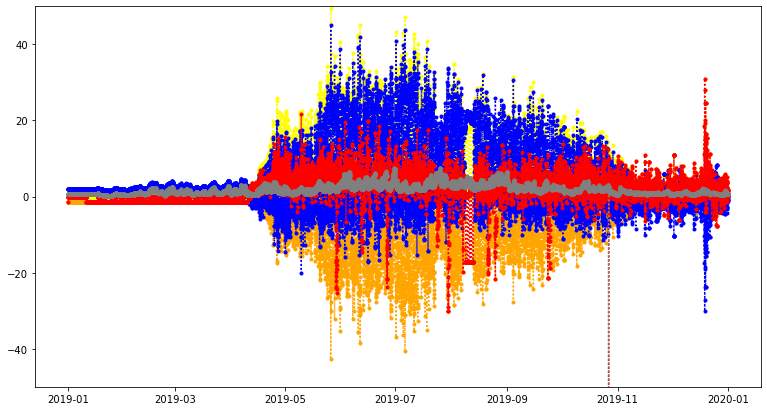

In [8]:
fig, axes=plt.subplots(figsize=(13,7))

axes.plot(df[carbonflux+'_f'], marker='.', linestyle=':', ms = 6, color = 'orange', 
             label='Serie original')

axes.plot(df[rei_gpp+'_f'], marker='.', linestyle=':', ms = 6, color = 'yellow', 
             label='Serie original')

axes.plot(df[fal_gpp+'_f'], marker='.', linestyle=':', ms = 6, color = 'blue', 
             label='Serie original')

axes.plot(df[rei_res], marker='.', linestyle=':', ms = 6, color = 'red', 
             label='Serie original')

axes.plot(df[fal_res], marker='.', linestyle=':', ms = 6, color = 'gray', 
             label='Serie original')

axes.set_ylim(-50, 50)

30-minute non-filled data

(-100.0, 100.0)

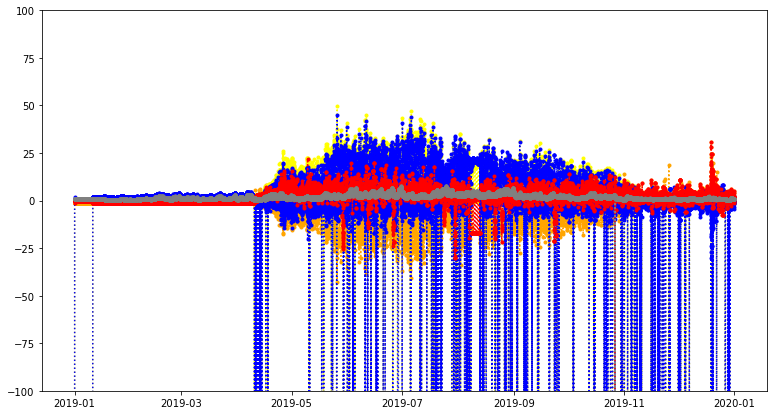

In [9]:
fig, axes=plt.subplots(figsize=(13,7))

axes.plot(df[carbonflux], marker='.', linestyle=':', ms = 6, color = 'orange', 
             label='Serie original')

axes.plot(df[rei_gpp], marker='.', linestyle=':', ms = 6, color = 'yellow', 
             label='Serie original')

axes.plot(df[fal_gpp], marker='.', linestyle=':', ms = 6, color = 'blue', 
             label='Serie original')

axes.plot(df[rei_res], marker='.', linestyle=':', ms = 6, color = 'red', 
             label='Serie original')

axes.plot(df[fal_res], marker='.', linestyle=':', ms = 6, color = 'gray', 
             label='Serie original')

axes.set_ylim(-100, 100)

In [10]:
# Tools to get GPP for specific periods (mean and sum)
date1 = '2019-01-01'
date2 = '2019-01-31'

gpp_analysis_A = df_gpp_smoth.loc[(df_gpp_smoth.index >= date1) & (df_gpp_smoth.index < date2) ]

gpp_analysis_B = gpp_analysis_A.describe()

gpp_analysis_C = gpp_analysis_A.copy().sum()

In [ ]:
    #*********************************************************************************************************************************************************************     
    if climatological_footprint:
        
        print('10)   Climatological footprint')
        t81 = ptime.time()
        
        #-------------------------------------------------------------------------------------------------------------------
        # load carbon flux file  
        
        df_carbonflux = df.loc[dff[carbonflux]==0].copy(deep=True)
        df_carbonflux.replace(undef, np.nan, inplace=True)
        df_carbonflux = df_carbonflux.loc[df['USTAR']>0.1]
        
        #-------------------------------------------------------------------------------------------------------------------

        # metadata parameters
        fetch = 100*(instrument_height_anenometer - displacement_height) #Fetch to height ratio https://www.mdpi.com/2073-4433/10/6/299
                                                                         #https://nicholas.duke.edu/people/faculty/katul/Matlab_footprint.html  
        # footprint variables 
        #domaint_var  = [-2000., 2000., -2000., 2000.]
        #nxt_var      = 1000
        #rst_var      = [20.,40.,60.,80.]   
        
        domaint_var  = domaint_var
        nxt_var      = nxt_var
        rst_var      = rst_var
        
        # function to add date variables to DataFrame.
        def add_date_info(df):

            df['Timestamp'] = pd.to_datetime(df['TIMESTAMP_END']) 
            df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
            df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
            df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
            df['Hour'] = pd.DatetimeIndex(df['Timestamp']).hour
            df['Minute'] = pd.DatetimeIndex(df['Timestamp']).minute

            return df
        
        # function to add ffp data to the data frame
        def add_ffp_info(df):

            df['zm']              = instrument_height_anenometer
            df['d']               = displacement_height
            df['z0']              = roughness_lenght    
            df_ec_variables       = ['Year','Month','Day','Hour','Minute',
                                     'zm','d','z0','WS','MO_LENGTH','V_SIGMA','USTAR','WD']
            ffp_variables         = ['yyyy','mm','day','HH_UTC','MM',
                                     'zm','d','z0','u_mean','L','sigma_v','u_star','wind_dir']
            df = df.loc[:,df_ec_variables].set_axis(ffp_variables , axis=1)

            return df
        
        # function to create files for the online tool 
        def online_format_by_year(df, year):
            
            # select only selected year
            df = df[df['yyyy']==year].copy(deep=True) 
            
            # compute mean velocity friction
            df_u_mean = df['u_mean'].mean()
            df['u_mean'] = df_u_mean
            
            # remove index info from file
            df_online = df.set_index('yyyy')
            
            # save file
            filepath = outputdir +'/Footprint_output/'
            df_online.to_csv(filepath + ID + "_ffp_online_data_"+ str(year) + ".csv")
            
            return df_online
        
        # function to create a climatological footprint per year
        def python_tool_by_year(df, year):
        
            df = df[df['yyyy']==year].copy(deep=True) 
            df_u_mean = df['u_mean'].mean()
            df['u_mean'] = df_u_mean
            
            # brings a code with the FPP model 
            %run FFP_Python/calc_footprint_FFP_climatology.py
        
            # defines h (boundary layer height) in convective conditions 
            df['h_convective'] = boundary_layer_height
            
            # function that adds boundary layer height info for stable conditions
            def add_bl(df): 
                
                angular_velocity = 7.29e-05               # angular velocity of the Earth’s rotation
                radianes = (latitude* math.pi)/180
                f = 2*angular_velocity*math.sin(radianes) # coriolis parameter
                df['h_stable'] = df['L']/3.8*(-1+( 1 + 2.28 * df['u_star']/(f*df['L']))**0.5)
                return df  
            
            # defines h (boundary layer height) in stable conditions 
            df = add_bl(df)
            
            # functions to differenciate between stable and convective conditions with the L parameter 
            def stable(L): 
                if L < 10:
                    bl = 0
                else:
                    bl = 1
                return bl
            
            def convective(L): 
                if L < 10:
                    bl = 1
                else:
                    bl = 0
                return bl
            
            df['stable']     = df['L'].apply(stable)
            df['convective'] = df['L'].apply(convective)
            
            df.replace(np.nan, -999, inplace=True) 
            
            # add h (boundary layer height) parameter
            df['h'] =  df['h_convective']*df['convective']
            df['h'] =  df['h'] + df['h_stable']*df['stable']
        
            # function to convert dataframe columns into list (used in the tool)
            def variablesToList(df):

                zmt      = df['zm'].to_numpy().tolist()             #0
                z0t      = df['z0'].to_numpy().tolist()             #1
                u_meant  = df['u_mean'].to_numpy().tolist()         #2
                ht       = df['h'].to_numpy().tolist()              #3
                olt      = df['L'].to_numpy().tolist()              #4
                sigmavt  = df['sigma_v'].to_numpy().tolist()        #5
                ustart   = df['u_star'].to_numpy().tolist()         #6
                wind_dirt= df['wind_dir'].to_numpy().tolist()       #7
                domaint  = domaint_var
                nxt      = nxt_var
                rst      = rst_var
                return zmt,z0t,u_meant,ht,olt,sigmavt,ustart,wind_dirt,domaint,rst
            
            ffp = variablesToList(df)
            
            # function to calcuate the footprint
            def calculateFootprint(list):
                l = list
                FFP = FFP_climatology (zm=l[0], z0=None, umean = l[2], h=l[3], ol=l[4], sigmav=l[5],
                ustar=l[6], wind_dir=l[7], domain=l[8], nx=None, rs=l[9],smooth_data=1, fig=1)
                return FFP
            
            footprint = calculateFootprint(ffp)

            return footprint  
        
        # add date and labels info
        df_ffp  = add_date_info(df_carbonflux.reset_index())
        df_ffp  = add_ffp_info(df_ffp).dropna(subset=['yyyy'])
        
        # create a only file per year identified in the input files
        years = df_ffp['yyyy'].unique().tolist()
        
        for i in years:
            globals()['df_online_%s' % i] = online_format_by_year(df_ffp, i)
            print('      File: df_online_%s' % i)
        
        # create aclimatological footprint per year
        if not calculated_ffp:  
            for i in years:

                print('  \n      Footprint for the year ', i)
                globals()['df_python_footprint_%s' % i] = python_tool_by_year(df_ffp, i)

                fp = globals()['df_python_footprint_%s' % i] 

                filename = 'df_python_footprint_' + str(i)
                print('      Created file: ', filename)

                # transforme x,y values in geographical coordinates
                projection = projection_site                                                                    #This is an input with the format of QGIS
                pro = Proj(projection)

                lat = latitude     
                lon = longitude    

                UTMlon, UTMlat     = pro(lon, lat)
                geo_lon, geo_lat   = pro(UTMlon, UTMlat , inverse=True)

                # tranformation per contour line 
                for n in range(len(rst_var)):

                        print('      Contour line:', rst_var[n])

                        # create a data frame with the x,y data per contour line
                        x = fp['xr'][n]
                        y = fp['yr'][n]

                        d_ffp = {'x': x, 'y': y}

                        ffp = pd.DataFrame(data=d_ffp)

                        # transform x,y data into UTM
                        ffp['UTMlon'] = UTMlon
                        ffp['UTMlat'] = UTMlat

                        ffp['X'] = ffp['x'] + ffp['UTMlon'] 
                        ffp['Y'] = ffp['y'] + ffp['UTMlat']

                        # transform UTM into geographical coordinates

                        ffp['lon'], ffp['lat'] = pro(ffp['X'].values, ffp['Y'].values, inverse=True)
                        globals()['footprint_%s_%d' %(int(rst_var[n]),i)] = ffp[['lon','lat']]

                        # export file
                        ffp_export = globals()['footprint_%s_%d' %(int(rst_var[n]),i)]
                        filepath = outputdir +'/Footprint_output/'
                        ffp_export.to_csv(filepath + ID + "_footprint_" + str(int(rst_var[n])) + '_' + str(i)+ ".csv")

                        print("      Exporting: footprint_" + str(int(rst_var[n])) + '_' + str(i))

        if calculated_ffp:
            for i in years:
                for n in range(len(rst_var)):
                        df_ffp_name ="Output/Footprint_output/" + ID + "_"+ 'footprint_%s_%d'%(int(rst_var[n]),i) +  ".csv"
                        globals()['footprint_%s_%d' %(int(rst_var[n]),i)] = pd.read_csv(df_ffp_name, index_col=0, header=0)

        t82   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t82 - t81) / 60.)                                                      
                  if (t82 - t81) > 60.
                  else '{:d} [seconds]'.format(int(t82 - t81))
                )
        print('     Computation climatological footprint in ', strin)    
        
 

10)   Climatological footprint
      File: df_online_2019
  
      Footprint for the year  2019

Alert(0014):
 No valid z0 passed, using umean.
 Execution continues.

Calculating footprint  1  of  16439
Calculating footprint  822  of  16439
Calculating footprint  1643  of  16439
Calculating footprint  2464  of  16439
Calculating footprint  3285  of  16439


# Plot climatological footprint

In [ ]:
for i in years:
    fig, ax = plt.subplots(figsize=(14, 14))
    for n in range(len(rst_var)):
            df_plot_ffp = globals()['footprint_%s_%d' %(int(rst_var[n]),i)]
            ax.scatter(df_plot_ffp['lon'], df_plot_ffp['lat'],
               c='black', alpha=0.2, label='20')

In [ ]:
    #*********************************************************************************************************************************************************************     
    if vegetation_indices:
        
        print('11)   Vegetation indices time series')
        t91 = ptime.time()

        import ee
        #ee.Authenticate() #For authentifications we require a Google Account registered in GEE (https://earthengine.google.com/)
        ee.Initialize()    

In [ ]:
        # create climatological footprint as ee object
        for i in years:
            print('      Creating climatological footprint for %d'%i) 
            # create geometries 
            for n in range(len(rst_var)):
                    
                df = globals()['footprint_%s_%d' %(int(rst_var[n]),i)].to_numpy().tolist()
                globals()['df_%s_%d_poly' %(int(rst_var[n]),i)] = ee.Geometry.Polygon(coords = df)
                print('      Transforming df_%s_%d_poly' %(int(rst_var[n]),i))

            lon_lat         =  [longitude, latitude]
            point = ee.Geometry.Point(lon_lat)
            globals()['df_fetch_%s_poly' %i]   = point.buffer(fetch)
            print('      Transforming df_fetch_%s_poly' %i)
            
            # create areas
            globals()['area_%s_%d' %(int(rst_var[0]),i)] = globals()['df_%s_%d_poly' %(int(rst_var[0]),i)]
            print('      Creating area_%s_%d' %(int(rst_var[0]),i))
            
            
            for n in range(len(rst_var)-1):
                globals()['area_%s_%d' %(int(rst_var[n+1]),i)]  = globals()['df_%s_%d_poly' %(int(rst_var[n+1]),i)].difference(globals()['df_%s_%d_poly' %(int(rst_var[n]),i)])
                print('      Creating area_%s_%d' %(int(rst_var[n+1]),i))  

            globals()['area_100_%d' %(i)]  = globals()['df_fetch_%s_poly' %i].difference(globals()['df_%s_%d_poly' %(int(rst_var[-1]),i)])
            print('      Creating area_100_%d ' %(i))
            print('\n') 

        # create range according to data in the input datafiles   
        start   = '%s-01-01'   %years[0]                                               #2017-05-12 starts frequency of 10 days                                               
        end     = '%s-12-31'   %years[-1]                                              #2017-12-18 starts frequency of 5 days
        timeSD  = [start, end]

        # create coordinates of the eddy covariance tower
        lon_lat         =  [longitude, latitude]         
        point = ee.Geometry.Point(lon_lat)

        # collections google earth engine    
        COPERNICUS_S2_L2A = 'COPERNICUS/S2_SR'                   #Multi-spectral surface reflectances (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)
        MODIS_temp        = 'MODIS/006/MOD11A1'                  #Land surface temperature (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1)
        USAID_prec        = 'UCSB-CHG/CHIRPS/DAILY'              #InfraRed Precipitation with Station dat (https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)
        MODIS_GPP         = 'MODIS/006/MOD17A2H'                 #Gross primary productivity(https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A2H)
        MODIS_NPP         = 'MODIS/006/MOD17A3HGF'               #Net primary productivity (https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD17A3HGF)
        
        # bands of the EO products used in the analysis
        # image.bandNames().getInfo() can be used to request bands of colections as well
        COPERNICUS_S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'QA10', 'QA20', 'QA60']
        MODIS_temp_bands    = ['LST_Day_1km','QC_Day','Day_view_time','Day_view_angle','LST_Night_1km','QC_Night','Night_view_time','Night_view_angle','Emis_31','Emis_32','Clear_day_cov','Clear_night_cov']
        USAID_prec_bands    = ['precipitation']
        MODIS_GPP_bands     = ['Gpp', 'PsnNet', 'Psn_QC']
        MODIS_NPP_bands     = ['Npp', 'Npp_QC']

        # function to load data set with specified period and location
        def load_catalog(catalog, time, location, bands):
            dataset = ee.ImageCollection(catalog).filterDate(time[0],time[1]).filterBounds(location).select(bands)
            return dataset

        # cloud coverage filter function
        def cloud_filter(collection, cloud_coverage_metadata_name, threshold):
            collection_cf = collection.filterMetadata(cloud_coverage_metadata_name,'less_than', threshold)
            return collection_cf
        
        # function to derive VIs
        def calculateVI(image):
            '''This method calculates different vegetation indices in a image collection and adds their values as new bands'''

            # defining dictionary of bands Sentinel-2 
            dict_bands = {

                "blue"  :  'B2',                              #Blue band                        
                "green" :  'B3',                              #Green band
                "red"   :  'B4',                              #Red band

                "red1"  :  'B5',                              #Red-edge spectral band   
                "red2"  :  'B6',                              #Red-edge spectral band
                "red3"  :  'B7',                              #Red-edge spectral band    
                "NIR"   :  'B8',                              #Near-infrared band
                "NIRn"  :  'B8A',                             #Near-infrared narrow

                "WV"    :  'B9',                              #Water vapour
                "SWIR1" :  'B11',                             #Short wave infrared 1
                "SWIR2" :  'B12',                             #Short wave infrared 2
            }
            
            # specify bands 
            dict  = dict_bands
            blue  = dict["blue"]                              #Blue band                        
            green = dict["green"]                             #Green band
            red   = dict["red"]                               #Red band
            red1  = dict["red1"]                              #Red-edge spectral band    
            red2  = dict["red2"]                              #Red-edge spectral band
            red3  = dict["red3"]                              #Red-edge spectral band
            NIR   = dict["NIR"]                               #Near-infrared band
            NIRn  = dict["NIRn"]                              #Near-infrared band
            
            WV    = dict["WV"]                                #Water vapour
            SWIR1 = dict["SWIR1"]                             #Short wave infrared 1
            SWIR2 = dict["SWIR2"]                             #Short wave infrared 2

            bands_for_expressions = {
                
                'blue'  : image.select(blue).divide(10000),
                'green' : image.select(green).divide(10000), 
                'red'   : image.select(red).divide(10000),
                'red1'  : image.select(red1).divide(10000), 
                'red2'  : image.select(red2).divide(10000),
                'red3'  : image.select(red3).divide(10000), 
                'NIR'   : image.select(NIR).divide(10000),
                'NIRn'  : image.select(NIRn).divide(10000),
                'WV'    : image.select(WV).divide(10000),
                'SWIR1' : image.select(SWIR1).divide(10000),
                'SWIR2' : image.select(SWIR2).divide(10000)}

            # greeness related indices
            # NDVI                                                                            (Rouse et al., 1974)
            NDVI  = image.normalizedDifference([NIR, red]).rename("NDVI") 
            # EVI                                                                             
            EVI   = image.expression('2.5*(( NIR - red ) / ( NIR + 6 * red - 7.5 * blue + 1 ))', 
                    bands_for_expressions).rename("EVI")
            # EVI2                                                                            (Jiang et al., 2008)
            EVI2  = image.expression('2.5*(( NIR - red ) / ( NIR + 2.4 * red + 1 ))', 
                    bands_for_expressions).rename("EVI2")
            
            # greeness related indices with Sentinel-2 narrow bands / Red-edge
            # Clr
            CLr  = image.expression('(red3/red1)-1', bands_for_expressions).rename("CLr")
            # Clg
            Clg  = image.expression('(red3/green)-1', bands_for_expressions).rename("CLg")
            # MTCI
            MTCI = image.expression('(red2-red1)/(red1-red)', bands_for_expressions).rename("MTCI")
            # MNDVI                                                                          (Add reference)
            MNDVI = image.normalizedDifference([red3, red1]).rename("MNDVI")    
            
            # water related indices
            # MNDWI                                                                          (Add reference)
            MNDWI = image.normalizedDifference([green, SWIR1]).rename("MNDWI")    
            # NDWI OR LSWI or NDII or NDMI                                                    (Add reference)
            LSWI  = image.normalizedDifference([NIR, SWIR1]).rename("LSWI")
            # NDII                                                                            (Hunt & Qu, 2013)
            NDII   = image.normalizedDifference([NIR, SWIR2]).rename("NDII")
 
            image1 = image.addBands(NDVI).addBands(EVI).addBands(EVI2)
            image2 = image1.addBands(CLr).addBands(Clg).addBands(MTCI).addBands(MNDVI)
            image3 = image2.addBands(MNDWI).addBands(LSWI).addBands(NDII)

            return image3  
        
        # function for masking non-vegetation areas
        def maskS2nonvegetation(image):

            qa    = image.select('QA60')
            scl   = image.select('SCL')
            ndvi  = image.select('NDVI')
            mndvi = image.select('MNDVI')

            cloudBitMask = 1 << 10
            cirrusBitMask = 1 << 11

            #vegetationMask1 = 4 # vegetation
            #vegetationMask2 = 5 # non-vegetated
            #vegetationMask3 = 6 # water
            #vegetationMask4 = 7 # unclassified

            #ndviMask  = -100;   # set in the config file
            #mndviMask = -100; 
            
            # this mask selects vegetation + non-vegetated + water + free cloud areas + areas with VIs (NDVI and MNDVI) greater that a threshold set in the Config file
            mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(7)).And(qa.bitwiseAnd(cloudBitMask).eq(0)).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(ndvi.gte(ndviMask)).And(mndvi.gte(mndviMask))

            vegetation = image.updateMask(mask)

            return vegetation
        
        # function to transform ee objects to dataframes pandas objects
        # function that transforms arrays into dataframes
        def ee_array_to_df(imagecollection, geometry, scale):
            
            """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
            
            # select bands from the image collection
            filtered = imagecollection.select(bands)
            
            # function that produce functions to reduce a region with atatistics (mean, max, min, etc.)
            def create_reduce_region_function(geometry,
                                              reducer=ee.Reducer.mean(),
                                              scale=1000,
                                              crs=crs,
                                              bestEffort=True,
                                              maxPixels=1e13,
                                              tileScale=4):

                  def reduce_region_function(img):

                    stat = img.reduceRegion(
                        reducer=reducer,
                        geometry=geometry,
                        scale=scale,
                        crs=crs,
                        bestEffort=bestEffort,
                        maxPixels=maxPixels,
                        tileScale=tileScale)

                    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
                  return reduce_region_function
                
            # function to transfer feature properties to a dictionary.
            def fc_to_dict(fc):
                    prop_names = fc.first().propertyNames()
                    prop_lists = fc.reduceColumns(reducer=ee.Reducer.toList().repeat(prop_names.size()),selectors=prop_names).get('list')

                    return ee.Dictionary.fromLists(prop_names, prop_lists)
            
            # creating reduction function (reduce_VI is a function)
            reduce_VI = create_reduce_region_function(
                geometry= geometry, reducer=ee.Reducer.mean(), scale=10, crs= crs)
            
            # transform image collection into feature collection (tables)
            VI_stat_fc = ee.FeatureCollection(imagecollection.map(reduce_VI)).filter(
                ee.Filter.notNull(imagecollection.first().bandNames()))
            
            # transform feature collection into dictionary object
            VI_dict = fc_to_dict(VI_stat_fc).getInfo()

            #print(type(VI_dict), '\n')
            
            #for prop in VI_dict.keys():
            #    print(prop + ':', VI_dict[prop][0:3] + ['...'])
            
            # transform dictionary into dataframe
            VI_df = pd.DataFrame(VI_dict)
            
            # convert column in datatime type object
            #VI_df['datetime'] = pd.to_datetime(VI_df['time'], unit='ms')
            VI_df['date']     = pd.to_datetime(VI_df['millis'], unit='ms').dt.date
            
            # generate a list with the names of each band of the collection 
            list_of_bands = filtered.first().bandNames().getInfo()
            
            # remove rows without data inside.
            VI_df = VI_df[['date', *list_of_bands]].dropna()
            
            # convert the data to numeric values.
            for band in list_of_bands:
                VI_df[band] = pd.to_numeric(VI_df[band], errors='coerce', downcast ='float')
                
            # convert the time field into a datetime.
            #VI_df['datetime'] = pd.to_datetime(VI_df['time'], unit='ms')
            #VI_df['date']     = pd.to_datetime(VI_df['time'], unit='ms').dt.date

            # keep the columns of interest.
            #VI_df = VI_df[['datetime','date',  *list_of_bands]]
            
            # flag to identify if in the reduction there were pixels, or they were masked-removed
            VI_df['flag'] = 100
            
            # reduction in case there are two pixels from different images for the same day
            VI_df = VI_df.groupby('date').mean().reset_index().set_index('date').copy()

            return VI_df

        # applying functions 

        # request of catalogues 
        S2     = load_catalog(COPERNICUS_S2_L2A, timeSD, point, COPERNICUS_S2_bands)
        temp   = load_catalog(MODIS_temp,        timeSD, point, MODIS_temp_bands)
        prec   = load_catalog(USAID_prec,        timeSD, point, USAID_prec_bands)
        gpp_MODIS    = load_catalog(MODIS_GPP,         timeSD, point, MODIS_GPP_bands)
        npp_MODIS    = load_catalog(MODIS_NPP,         timeSD, point,  MODIS_NPP_bands)

        # filter cloud coverage
        cloud_coverage_metadata_name = 'CLOUDY_PIXEL_PERCENTAGE'                     # name of metadata property indicating cloud coverage in %

        # applying cloud filter 
        S2_VI = cloud_filter(S2, cloud_coverage_metadata_name, max_cloud_coverage)   # max cloud coverage defined in the Config file

        # calculation of vegetation indices for the collection
        S2_VI = S2_VI.map(calculateVI)
        
        # applying mask 
        S2_VI = S2_VI.map(maskS2nonvegetation)

        # select bands for the analysis of interdependency and regression models 
        #bands = ['NDVI','EVI','EVI2','CLr','CLg','MTCI','MNDVI','MNDWI','LSWI','NDII']
        bands = ['NDVI','EVI','EVI2','CLr','MNDVI','MNDWI','LSWI','NDII']
    
        # applying funtion ee_array_to_df for each climatological footprint
        for i in years:
            for n in range(len(rst_var)):

                    area = globals()['area_%s_%d' %(int(rst_var[n]),i)]
                    globals()['S2_VI_df_area_%s_%d' %(int(rst_var[n]),i)]  = ee_array_to_df(S2_VI, area, 60)          
                    print('      Retrieving info from area_%s_%d into dataframe:' %(int(rst_var[n]),i))
                    print('      S2_VI_df_area_%s_%d' %(int(rst_var[n]),i))


            area = globals()['area_100_%d' %i]
            globals()['S2_VI_df_area_100_%d' %i]  = ee_array_to_df(S2_VI, area, 60) 
            print('      Retrieving info from area_100_%d into dataframe:' %i)
            print('      S2_VI_df_area_100_%d' %i)
            print('\n')

        # loop to derive a weighted value of each VI per climatological footprint
        for i in years:
            
            # create an empty file
            globals()['dfvi_%s'%i] = pd.DataFrame(columns=bands)
            
            for n in range(len(rst_var)):

                    df = globals()['S2_VI_df_area_%s_%d' %(int(rst_var[n]),i)].multiply(0.2)  
                    print('      Concat S2_VI_df_area_%s_%d' %(int(rst_var[n]),i))
                    globals()['dfvi_%s'%i] = pd.concat([globals()['dfvi_%s'%i], df])

            df = globals()['S2_VI_df_area_100_%d' %i].multiply(0.2)
            print('      Concat S2_VI_df_area_100_%d' %i)
            globals()['dfvi_%s'%i] = pd.concat([globals()['dfvi_%s'%i] , df])
            
            globals()['S2_VI_ffp_%s'%i] = globals()['dfvi_%s'%i].groupby(globals()['dfvi_%s'%i].index).sum().rename_axis('date')
            print('      Creating S2_VI_ffp_%s'%i)
            print('\n') 

        # loop to derive the mean value of the vegetation indixes per region and per year
        for i in years:

            globals()['dfvi_mean_%s'%i] = pd.DataFrame(columns=bands)

            for n in range(len(rst_var)):

                    df = globals()['S2_VI_df_area_%s_%d' %(int(rst_var[n]),i)].describe().loc['mean':'std',bands[0]: bands[-1]]                  
                    df.drop(['std'], inplace = True)
                    df['Index'] = int(rst_var[n])
                    df.set_index('Index', inplace = True)
                    globals()['dfvi_mean_%s'%i] = pd.concat([globals()['dfvi_mean_%s'%i], df])

            df = globals()['S2_VI_df_area_100_%d' %i].describe().loc['mean':'std',bands[0]: bands[-1]]
            df.drop(['std'], inplace = True)
            df['Index'] = int(100)
            df.set_index('Index', inplace = True)

            globals()['dfvi_mean_%s'%i] = pd.concat(([globals()['dfvi_mean_%s'%i] , df]), axis = 0)
            globals()['dfvi_mean_%s'%i].to_csv(outputdir + '/VI_output/' + ID + '_dfvi_mean_%s'%i+'.csv')
            print('      Creating dfvi_mean_%s'%i)
            print('\n') 

        # loop to join each S2_VI_df in a single dataframe per year named as df_VI
        df_VI = pd.DataFrame(columns=bands)
        
        ndvi_threshold = -100                                                            # Threshold applied in the time series. Not used in the analysis

        for i in years:

            globals()['S2_VI_ffp_%s_join'%i] = globals()['S2_VI_ffp_%s'%i][globals()['S2_VI_ffp_%s'%i]['NDVI']>ndvi_threshold]

            def add_date_info(df):

                df = df.reset_index()
                df['date'] = pd.to_datetime(df['date'])
                df['Year'] = pd.DatetimeIndex(df['date']).year

                def timestamp(df):
                    df = df.timestamp()
                    return df

                df['timestamp'] = df['date'].apply(timestamp)
                df = df.set_index('date')
                
                return df

            globals()['S2_VI_ffp_%s_join'%i]  = add_date_info(globals()['S2_VI_ffp_%s_join'%i] )
            globals()['S2_VI_ffp_%s_join'%i]  = globals()['S2_VI_ffp_%s_join'%i][globals()['S2_VI_ffp_%s_join'%i]['Year'] == i]

            df = globals()['S2_VI_ffp_%s_join'%i]
            print('      Concat S2_VI_ffp_%s_join'%i)

            df_VI = pd.concat([df_VI, df]).rename_axis('date')
        print('      Creating df_VI')
        print('\n') 

        # filtering VI_eshape by flag. Removes dates when there were areas whitin the climatological footprint that were totally masked 
        df_VI_filtered = df_VI.copy()
        df_VI_filtered = df_VI_filtered[df_VI_filtered['flag']>80].drop(['flag'], axis = 1)

        # create time series with daily frequency
        time_series = pd.date_range(start=start, end=end, freq="D")
        time_series = pd.DataFrame(time_series).rename(columns={0: 'date'}).set_index('date')

        # allows to have a time series with daily frequency with gaps when the VI were not calculated or there were not S2 images
        df_VI_time = pd.merge(left= time_series, right = df_VI_filtered,
                                     how="left", left_index = True , right_index = True)  
        
        # interpolate values
        df_VI_interpolate = df_VI_time.interpolate(method='akima', order=1, limit_direction ='forward')
        #df_VI_interpolate_limits = df_VI_interpolate.apply(lambda x: x.interpolate(method="spline", order=6))
        df_VI_interpolate = df_VI_interpolate.fillna(method='backfill')
        df_VI_interpolate = df_VI_interpolate.fillna(method='ffill')

        # file to extrapolate
        df_VI_export = df_VI_interpolate.dropna().drop(['Year','timestamp'], axis = 1) 
        df_VI_export.to_csv(outputdir + '/VI_output/' + ID + "_Vegetation_indices.csv")   

        print("      Exporting: Vegetation_indices.csv")
        print('\n') 

        #---------------------------------------------------------------------------------------------

        t92   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t92 - t91) / 60.)                                                      
                  if (t92 - t91) > 60.
                  else '{:d} [seconds]'.format(int(t92 - t91))
                )
        print('     Computation vegetation indices in ', strin)  

# Plots vegetation indices

In [ ]:
# function to display plots of VI
def plot_timeseries_vi_multiple(df):
    # subplots.
    fig, ax = plt.subplots(figsize=(14, 6)) #Indicates the size of the plot

    # add scatter plots //Adds the scatter points
    ax.plot(df['NDVI'],
               c='#00FF00', alpha=1, label='NDVI', lw=2, linestyle = ':')
    ax.plot(df['EVI'],
               c='red', alpha=1, label='EVI', lw=2, linestyle = ':')
    ax.plot(df['EVI2'],
               c='yellow', alpha=1, label='EVI-2', lw=2, linestyle = ':')
    ax.plot(df['CLr'],
               c='green', alpha=1, label='CLr', lw=2, linestyle = ':')
    ax.plot(df['MNDVI'],
               c='black', alpha=1, label='MNDVI', lw=2, linestyle = ':')
    ax.plot(df['MNDWI'],
               c='#00FFFF', alpha=0.5, label='MNDWI', lw=2, linestyle = '-.')
    ax.plot(df['LSWI'],
               c='blue', alpha=0.8, label='LSWI', lw=2, linestyle = '-.')
    ax.plot(df['NDII'],
               c='#00008B', alpha=0.8, label='NDII', lw=2, linestyle = '-.') #marker="x", markersize=2)

    ax.set_title('Vegetation Indices', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Vegetation Index', fontsize=14)
    ax.set_ylim(-1, 1)
    ax.grid(lw=0.5)
    ax.legend(fontsize=14, loc='lower right')
    
    # shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, .8))
    plt.savefig(outputdir + '/VI_output/' + ID + '_VI_timeseries.png', dpi=300, format='png', bbox_inches='tight',pad_inches=0.0001)

    return plt.show()

In [ ]:
def plot_timeseries_vi_single(df,df_original, VI):
    
    fig, ay = plt.subplots(figsize=(14, 6)) #Indicates the size of the plot
    ay.plot(df[VI], c='#00FF00', alpha=0.2, lw=5, label='Akima interpolation')

    df = df.reset_index()
    dff= df_original.reset_index()
    
    dff.plot(kind="scatter",x='date', y=VI, ax=ay, c='GREEN', alpha=0.80, label=VI.upper())

    ay.legend(fontsize=12, loc='upper right')

    ay.grid(lw=0.5)

    ay.set_title(VI, fontsize=16)
    ay.set_xlabel('Date', fontsize=14)
    ay.set_ylabel(VI, fontsize=14)
    
    return plt.show()

In [ ]:
df = df_VI_export.copy()
plot_timeseries_vi_multiple(df)
plot_timeseries_vi_single(df, df_VI_time, 'LSWI')
plot_timeseries_vi_single(df, df_VI_time, 'MNDVI')
plot_timeseries_vi_single(df, df_VI_time, 'NDVI')
plot_timeseries_vi_single(df, df_VI_time, 'EVI')

In [ ]:
# display info within specific dates
df = df_VI_export.copy()

date1 = '2019-01-01'
date2 = '2019-12-31'

a1 = df.loc[(df.index >= date1) & (df.index < date2)]
b1 = a1.describe()
c1 = a1.copy().sum()

In [ ]:
    #*********************************************************************************************************************************************************************     
    # list of dataframes with meteorological information
    EV_dataframes = []
    EV_dataframes_names = []
    #*********************************************************************************************************************************************************************     
    if environmental_variables_station:
        
        print('12a) Environmental variables time series from station')
        t101a = ptime.time()
        
        # function to apply rolling average and interpolation to meteorological data 
        def interpolation_rolling(df,window):
            df = df.interpolate(method='akima', order=1, limit_direction ='forward')
            df = df.rolling(window, center=True, min_periods=1).mean()
            return df
        
        # directory with the Data
        filepath = os.getcwd() + '\\Input'
        first_file= meteo_file
        
        # reading file meteorological station
        parser = lambda date: dt.datetime.strptime(date, '%Y-%m-%d')
        
        # meteorological data
        df_meteo_station = pd.read_csv(filepath + first_file,parse_dates=[0], date_parser=parser, index_col = [0])
        
        
        if df_rainfall_station_switch:
            
            print('      Computing: df_rainfall_station \n')
            
            # rainfall data
            df_rainfall_station = df_meteo_station.rename(columns={ precipitation_data[0] : 'RAIN'}).loc[:,'RAIN'].copy()  
            df_rainfall_station = pd.DataFrame(df_rainfall_station)

            # rainfall data with diferrent windows and delays
            window = [7,15,30,60,90]
            shifts = [7,15,30,60,90,120,150,180]

            for w in window:
                df_rainfall_station['RAIN_%s'%w]  = df_rainfall_station['RAIN'].rolling(window=w, center=True, min_periods=1).mean()

                for sh in shifts:
                        df_rainfall_station['RAIN_%s_%s'%(w,sh)]  = df_rainfall_station['RAIN_%s'%w].shift(+sh)
                           
            EV_dataframes.append(df_rainfall_station)
            EV_dataframes_names.append("df_rainfall_station")
                        
        if df_meteo_station_switch:
            
            print('      Computing: df_meteo_statio  \n')
            
            df_meteo_station   = interpolation_rolling(df_meteo_station,rolling_window_ev_meteo).drop(precipitation_data, axis = 1)
            
            EV_dataframes.append(df_meteo_station)
            EV_dataframes_names.append("df_meteo_station")

        t102a   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t102a - t101a) / 60.)                                                      
                  if (t102a - t101a) > 60.
                  else '{:d} [seconds]'.format(int(t102a - t101a))
                )
        print('     Computation environmental variables time series from station in', strin)  
        print('\n')

    #*********************************************************************************************************************************************************************     
 

In [ ]:
variable_meteo = 'TH'

# print time series
import altair as alt

data_meteo        = df_meteo_station.reset_index()
data_meteo_one    = data_meteo[['date',variable_meteo]].copy()
data_meteo_one    = data_meteo_one.rename(columns={
    variable_meteo: 'Variable',
})
data_co_fluxes.head(10)

alt.Chart(data_meteo_one).mark_bar(size=1).encode(
    x='date:T',
    y='Variable:Q',
    color=alt.Color(
        'Variable:Q', scale=alt.Scale(scheme='redyellowgreen', domain=(0, 14))),
    tooltip=[
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('Variable:Q', title='Variable')
    ]).properties(width=600, height=300)

In [ ]:
   if environmental_variables_satellite:
        
        print('12b) Environmental variables time series from satellite products')
        t101b = ptime.time()
        
        # function to transform ee objects into dataframes. It cannot process high resolution data due to the limitations of memory of ee API 
        # this method is only practical for coarse resolution Satellite Images. Give information for a specific pixel in the case of Sentinel 2
        def ee_array_to_df_coarse(imagecollection, geometry, scale):

            """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
 
            # ee objects are transformed into arrays for specific region (point + buffer)
            arr = imagecollection.getRegion(geometry, scale).getInfo()

            # generate a list with the names of each band of the collection 
            list_of_bands = imagecollection.first().bandNames().getInfo()

            # transforms arrays into dataframes
            df = pd.DataFrame(arr)

            # rearrange the header.
            headers = df.iloc[0]
            df = pd.DataFrame(df.values[1:], columns=headers).dropna()
            
            # convert the time field into a datetime.
            df['date']     = pd.to_datetime(df['time'], unit='ms') #.dt.date

            # convert the data to numeric values.
            for band in list_of_bands:
                df[band] = pd.to_numeric(df[band], errors='coerce', downcast ='float')

            # keep the columns of interest.
            df = df[['date',  *list_of_bands]]
            df = df.groupby('date').mean().reset_index().set_index('date')
            
            # create a time series with daily frequency
            time_series = pd.date_range(start, end, freq="D")
            time_series = pd.DataFrame(time_series).rename(columns={0: 'date'}).set_index('date')

            df  = pd.merge(left= time_series, right = df,
                           how="left", left_on ="date", right_on ="date")  
            return df
        
        # function to convert temperature to °C // Important to observe .apply method to apply a function over a list or df
        def t_modis_to_celsius(t_modis): 
            """Converts MODIS LST units to degrees Celsius."""
            t_celsius =  0.02*t_modis - 273.15
            return t_celsius
        
        # function to apply rolling average and interpolation to meteorological data 
        def interpolation_rolling(df,window):
            df = df.interpolate(method='akima', order=1, limit_direction ='forward')
            df = df.rolling(window, center=True, min_periods=1).mean()
            return df
            
        if df_rainfall_CHIRPS_switch:
            print('      Computing: df_rainfall_CHIRPS')
            # applying functions to derive precipitation data from MODIS catalog
            prec_dataframe     = ee_array_to_df_coarse(prec, point.buffer(fetch),100)
            prec_dataframe     = prec_dataframe.rename(columns={ 'precipitation': 'RAIN_C'})       
            df_rainfall_CHIRPS = prec_dataframe.copy()

            # rainfall data with diferrent windows and delays
            window = [7,15,30,60,90]
            shifts = [7,15,30,60,90,120,150,180]

            for w in window:
                df_rainfall_CHIRPS['RAIN_C_%s'%w]  = df_rainfall_CHIRPS['RAIN_C'].rolling(window=w, center=True, min_periods=1).mean()

                for sh in shifts:
                        df_rainfall_CHIRPS['RAIN_C_%s_%s'%(w,sh)]  = df_rainfall_CHIRPS['RAIN_C_%s'%w] .shift(+sh)

            EV_dataframes.append(df_rainfall_CHIRPS)
            EV_dataframes_names.append("df_rainfall_CHIRPS")
            
        if df_temp_MODIS_switch:
            print('      Computing: df_temp_MODIS')
            # applying functions to derive temperature data from MODIS catalog
            temp_dataframe = ee_array_to_df_coarse(temp.select('LST_Day_1km'), point.buffer(fetch),100)
            temp_dataframe = temp_dataframe.rename(columns={'LST_Day_1km': 'TA_MODIS'}).apply(t_modis_to_celsius)
            df_temp_MODIS  = interpolation_rolling(temp_dataframe,rolling_window_ev_meteo_sat)
            
            EV_dataframes.append(df_temp_MODIS)
            EV_dataframes_names.append("df_temp_MODIS")
            
        print('      Computing: df_gpp_MODIS')
        print('      Computing: df_npp_MODIS  \n')
        # applying functions to derive gpp data from MODIS catalog
        gpp_dataframe  = ee_array_to_df_coarse(gpp_MODIS, point.buffer(fetch),100)
        gpp_dataframe  = gpp_dataframe.divide(8).multiply(1000).multiply(0.0001)
        gpp_dataframe  = gpp_dataframe.rename(columns={ 'Gpp': 'GPP_MODIS'}).drop(['PsnNet', 'Psn_QC'], axis = 1)
        df_gpp_MODIS   = interpolation_rolling(gpp_dataframe,rolling_window_gpp_MODIS)
        
        # applying functions to derive precipitation data from MODIS catalog
        npp_dataframe = ee_array_to_df_coarse(npp_MODIS, point.buffer(fetch),100).multiply(1000).multiply(0.0001)
        df_npp_MODIS  = npp_dataframe.rename(columns={ 'Npp': 'NPP_MODIS'}).drop('Npp_QC', axis = 1)

        t102b   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t102b - t101b) / 60.)                                                      
                  if (t102b - t101b) > 60.
                  else '{:d} [seconds]'.format(int(t102b - t101b))
                )
        print('     Computation environmental variables time series from satellite products in', strin)  
        print('\n')

    #*********************************************************************************************************************************************************************     

In [ ]:
variable_meteo = 'GPP_MODIS'

# print time series
import altair as alt

data_meteo        = df_gpp_MODIS.reset_index()
data_meteo_one    = data_meteo[['date',variable_meteo]].copy()
data_meteo_one    = data_meteo_one.rename(columns={
    variable_meteo: 'Variable',
})
data_co_fluxes.head(10)

alt.Chart(data_meteo_one).mark_bar(size=1).encode(
    x='date:T',
    y='Variable:Q',
    color=alt.Color(
        'Variable:Q', scale=alt.Scale(scheme='redyellowgreen', domain=(0, 14))),
    tooltip=[
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('Variable:Q', title='Variable')
    ]).properties(width=600, height=300)

In [ ]:
  if tower_observations:
        
        print('12c) GPP and environmental time series from flux tower')
        t101c = ptime.time()
        
        if df_meteo_tower_switch:
            
            print('      Computing: df_meteo_tower')
            df_meteo_tower = df_gpp_smoth.copy(deep=True).drop([
              #'TA_f',
              #'VPD_f',
              #'SW_IN_f',
              carbonflux+'_f',
              rei_gpp+'_f',
              rei_res+'_f',
              fal_gpp+'_f',
              fal_res+'_f',
              las_gpp+'_f',
              las_res+'_f'], axis = 1)  
            
            df_meteo_tower = df_meteo_tower[df_meteo_tower['TA_f']<1000]
            df_meteo_tower = interpolation_rolling(df_meteo_tower,rolling_window_ev_meteo)

            EV_dataframes.append(df_meteo_tower)
            EV_dataframes_names.append("df_meteo_tower")

        erased_variables = ['TA_f', 'VPD_f', 'SW_IN_f', carbonflux+'_f', rei_res+'_f', fal_res+'_f',  las_res+'_f']   
        
        if rei_gpp_switch:
            erased_variables.append(fal_gpp+'_f')
            erased_variables.append(las_gpp+'_f')
            gpp_analysis = rei_gpp+'_f'
        if fal_gpp_switch:
            erased_variables.append(rei_gpp+'_f')
            erased_variables.append(las_gpp+'_f')
            gpp_analysis = fal_gpp+'_f'
        if las_gpp_switch:
            erased_variables.append(rei_gpp+'_f')
            erased_variables.append(fal_gpp+'_f')
            gpp_analysis = las_gpp+'_f'
            
        print('      Computing: df_gpp_tower\n')
        df_gpp_tower = df_gpp_smoth.copy(deep=True).drop(erased_variables, axis = 1).rename(columns={ gpp_analysis: 'GPP_observations'}) 
        
        t102c   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t102c - t101c) / 60.)                                                      
                  if (t102c - t101c) > 60.
                  else '{:d} [seconds]'.format(int(t102b - t101c))
                )
        print('     Computation environmental variables time series from satellite products in', strin)  
        print('\n')
 

In [ ]:
variable_meteo = 'SW_IN_f'

# print time series
import altair as alt

data_meteo        = df_meteo_tower.reset_index()
data_meteo_one    = data_meteo[['date',variable_meteo]].copy()
data_meteo_one    = data_meteo_one.rename(columns={
    variable_meteo: 'Variable',
})
data_co_fluxes.head(10)

alt.Chart(data_meteo_one).mark_bar(size=1).encode(
    x='date:T',
    y='Variable:Q',
    color=alt.Color(
        'Variable:Q', scale=alt.Scale(scheme='redyellowgreen', domain=(0, 14))),
    tooltip=[
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('Variable:Q', title='Variable')
    ]).properties(width=600, height=300)

In [ ]:
variable_meteo = 'GPP_observations'

# print time series
import altair as alt

data_meteo        = df_gpp_tower.reset_index()
data_meteo_one    = data_meteo[['date',variable_meteo]].copy()
data_meteo_one    = data_meteo_one.rename(columns={
    variable_meteo: 'Variable',
})
data_co_fluxes.head(10)

alt.Chart(data_meteo_one).mark_bar(size=1).encode(
    x='date:T',
    y='Variable:Q',
    color=alt.Color(
        'Variable:Q', scale=alt.Scale(scheme='redyellowgreen', domain=(0, 14))),
    tooltip=[
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('Variable:Q', title='Variable')
    ]).properties(width=600, height=300)

In [ ]:
    #*********************************************************************************************************************************************************************     
    if correlation_analysis:
        
        print('13a) Correlation analysis')
        t111a = ptime.time()
        
        # function that derives the analysis of interdependency betwee gpp and multiple variables, and selects the variable with higher correlation
        def correlation_single(gpp,variable,Top):
                
                # merging dataframes
                df_gpp = gpp.copy().dropna()
                df_gpp = pd.merge(left= df_gpp, right = variable,
                                how="left", left_index = True , right_index = True) 
                
                # correlation analysis
                correlation = df_gpp.corr()**2
                correlation_analysis    = correlation.reset_index().sort_values(by='GPP_observations', ascending=False)
                correlation_analysis    = correlation_analysis[['index','GPP_observations']].set_index('index')

                if isinstance(Top, int):
                    best_model = correlation_analysis.reset_index().iloc[Top,0]
                    best_r2    = correlation_analysis.reset_index().iloc[Top,1]
                    
                    print('The %s° higer correlated variable with GPP_observations is %s with R^2 = %.4f'%(Top, best_model,best_r2))
                    
                else:
                    best_model = Top 
                    best_r2    = correlation_analysis.loc[Top, 'GPP_observations']
                    print('The correlation of the %s model with GPP_observations is R^2 = %.4f'%(best_model,best_r2))

                # produce de linear model with the variable with higher correlation
                lm_1    = smf.ols(formula="GPP_observations~%s"%best_model, data = df_gpp).fit()

                pvalues = lm_1.pvalues
                params  = lm_1.params
                summary = lm_1.summary()
                print('The linear model  GPP = m (%s) + b has coefficients b = %.4f with p = %.4e and m= %.4f with p = %.4e' %(best_model,params[0],pvalues[0],params[1],pvalues[1]))
                
                # plot correlation between gpp and the variable with higher correlation
                #%matplotlib inline
                #df.plot(kind = "scatter", x = "%s"%best_model, y ="GPP_observations", c='green')

                return correlation_analysis, params, pvalues, summary, best_model, best_r2 
  
        # function that evaluates the correlation between independat variables to identify multicollinearity
        def multicollinearity(variable1,variable2,Top1, Top2):
                
                # merging dataframes
                df = variable1[Top1].copy().dropna()
                df = pd.merge(left= df, right = variable2,
                                how="left", left_index = True , right_index = True) 
                
                # correlation analysis
                correlation = df.corr()**2
                correlation_analysis    = correlation.reset_index().sort_values(by=Top1, ascending=False)
                correlation_analysis    = correlation_analysis[['index',Top1]].set_index('index')

                if isinstance(Top2, int):
                    best_model = correlation_analysis.reset_index().iloc[Top2,0]
                    best_r2    = correlation_analysis.reset_index().iloc[Top2,1]
                    print('The %s° higer correlated variable with %s is %s with R^2 = %.4f'%(Top2, Top1, best_model,best_r2))
                else:
                    best_model = Top2 
                    best_r2    = correlation_analysis.loc[Top2, Top1]
                    print('The correlation of the %s with %s is R^2 = %.4f'%(Top1, best_model,best_r2))
                
                if best_r2>0.5:
                    print('There is a high correlation between the independant variables %s and %s \n' %(Top1, best_model))
                else:
                    print('There is a low correlation between the independant variables %s and %s \n' %(Top1, best_model))
                
                # plot correlation betwen the selected variable from variable1 and the variable with higher correlation from variable2
                #%matplotlib inline
                #df.plot(kind = "scatter", x = "%s"%best_model, y ="%s"%Top1, c='green')

                return correlation_analysis
        
        # function that automatically derives the analysis of interdependecy between gpp, environmental variables and vegetation indices as performed by Cai et al. 2021
        def correlation_cai(gpp,VI,EV,Top):

                df_gpp = gpp.copy().dropna()

                X = VI.columns.to_list()
                Y = EV.columns.to_list()
                
                # loop to create VI*EV variables 
                for i in X:
                    for ii in Y:
                        stri = i+'_x_'+ii
                        df_gpp[stri] = VI[i]*EV[ii]
                
                # correlation analysis
                correlation = df_gpp.corr()**2
                correlation_analysis    = correlation.reset_index().sort_values(by='GPP_observations', ascending=False)
                correlation_analysis    = correlation_analysis[['index','GPP_observations']].set_index('index')

                if isinstance(Top, int):
                    best_model = correlation_analysis.reset_index().iloc[Top,0]
                    best_r2    = correlation_analysis.reset_index().iloc[Top,1]
                    print('The %s° best model with Shubert et al. (2012) structure is GPP = m (%s) + b with R^2 = %.4f'%(Top, best_model,best_r2))
                else:
                    best_model = Top 
                    best_r2    = correlation_analysis.loc[Top, 'GPP_observations']
                    print('The performance of the GPP = m (%s) + b model with Shubert et al. (2012) structure is R^2 = %.4f'%(best_model,best_r2))

                # produce de linear model with the variable with higher correlation
                lm_2    = smf.ols(formula="GPP_observations~%s"%best_model, data = df_gpp).fit()

                pvalues = lm_2.pvalues
                params  = lm_2.params
                summary = lm_2.summary()
                print('The linear coefficients are b = %.4f with p = %.4e and m= %.4f with p = %.4e ' %(params[0],pvalues[0],params[1],pvalues[1]))
                
                # plot correlation between gpp and the variable VI*EV with higher correlation
                #%matplotlib inline
                #df.plot(kind = "scatter", x = "%s"%best_model, y ="GPP_observations", c='green')

                return correlation_analysis, params, pvalues, summary, best_model, best_r2, df_gpp

        # function that presents the VI and VI*EV variables with higher correlation with gpp observations
        def full_correlation_analysis(df_EV,TopVI,TopCai):
            
            # selects de VI with higher correlation with gpp
            correlation_analysis_VI,params_VI,pvalues_VI,summary_VI,best_model_VI, best_r2_VI                = correlation_single(df_gpp_tower,df_VI_export  ,TopVI)
            
            df_VI_best = pd.DataFrame(df_VI_export[best_model_VI])
            correlation_analysis_cai,params_cai,pvalues_cai,summary_cai,best_model_cai, best_r2_cai, df_cai  = correlation_cai(df_gpp_tower,df_VI_best,df_EV ,TopCai)

            best_model_EV = best_model_cai.split('_x_')[1]
            correlation = multicollinearity(df_VI_export,df_EV, best_model_VI, best_model_EV)
            
            return best_model_cai, params_cai, pvalues_cai, best_r2_cai, summary_cai, df_cai, correlation_analysis_VI

        print('\n')
        print('     Using:', bands)
        print('     Using:', EV_dataframes_names)
        print('\n')
        
        # applying the functions
        EV_dataframes 
        best_model_cai_list = []
        best_model_VI_cai_list = []
        best_model_EV_cai_list = []
        params_cai_m_list   = []
        params_cai_b_list   = []
        pvalues_cai_m_list  = []
        pvalues_cai_b_list  = []
        best_r2_cai_list    = []
        summary_cai_list    = []


        for m in range(1, len(df_VI_export.columns)+1):
            for n in EV_dataframes:

                best_model_cai,params_cai,pvalues_cai, best_r2_cai,summary_cai, df_cai, correlation_analysis_VI = full_correlation_analysis(n,m,1) 
                best_model_VI_cai_list.append(best_model_cai.split('_x_')[0])
                best_model_EV_cai_list.append(best_model_cai.split('_x_')[1])
                best_model_cai_list.append(best_model_cai)

                params_cai_m_list.append(params_cai[1])
                params_cai_b_list.append(params_cai[0])
                pvalues_cai_m_list.append(pvalues_cai[1])
                pvalues_cai_b_list.append(pvalues_cai[0])
                best_r2_cai_list.append(best_r2_cai)
                summary_cai_list.append(summary_cai)


        models = {'best_model_cai_VI':best_model_VI_cai_list,
                  'best_model_cai_EV':best_model_EV_cai_list,
                  'best_model_cai':best_model_cai_list, 
                  'params_cai_m':params_cai_m_list ,
                  'params_cai_b':params_cai_b_list  , 
                  'pvalues_cai_m':pvalues_cai_m_list, 
                  'pvalues_cai_b':pvalues_cai_b_list, 
                  'best_r2_cai': best_r2_cai_list  }
        
        df_correlation         = pd.DataFrame(models)
        df_correlation_ranked  = df_correlation.reset_index().sort_values(by='best_r2_cai', ascending=False).reset_index(drop=True)
          
            
        # introduce in the upper section
        m_parameter        = df_correlation_ranked.loc[:0,'params_cai_m'][0]             #cte along the period
        b_parameter        = df_correlation_ranked.loc[:0,'params_cai_b'][0]             #cte along the period

        best_model_cai_EV  = df_correlation_ranked.loc[:0,'best_model_cai_EV'][0] 
        best_model_cai_VI  = df_correlation_ranked.loc[:0,'best_model_cai_VI'][0] 
        
        t112a   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t112a - t111a) / 60.)                                                      
                  if (t112a - t111a) > 60.
                  else '{:d} [seconds]'.format(int(t112a - t111a))
                )
        print('     Computed correlation analysis in ', strin)  

In [ ]:
    #*********************************************************************************************************************************************************************     
    if correlation_analysis_simple:
        
        print('13b) Correlation analysis')
        t111b = ptime.time()
        
        def correlation_cai_simple(gpp,VI,EV_list,Top):
            
                df_gpp = gpp.copy().dropna()
                
                # loop to create VI*EV variables 
                for EV in EV_list:

                    X = VI.columns.to_list()
                    Y = EV.columns.to_list()

                    for i in X:
                        for ii in Y:
                            stri = i+'_x_'+ii
                            df_gpp[stri] = VI[i]*EV[ii]
                
                data_mix    = df_gpp.copy()
                correlation = df_gpp.corr()**2
                correlation_analysis    = correlation.reset_index().sort_values(by='GPP_observations', ascending=False)
                correlation_analysis    = correlation_analysis[['index','GPP_observations']].set_index('index')

                if isinstance(Top, int):
                    best_model = correlation_analysis.reset_index().iloc[Top,0]
                    best_r2    = correlation_analysis.reset_index().iloc[Top,1]
                    print('The %s° best model with Shubert et al. (2012) structure is GPP = m (%s) + b with R^2 = %.4f'%(Top, best_model,best_r2))
                else:
                    best_model = Top 
                    best_r2    = correlation_analysis.loc[Top, 'GPP_observations']
                    print('The performance of the GPP = m (%s) + b model with Shubert et al. (2012) structure is R^2 = %.4f'%(best_model,best_r2))
                
                return data_mix, best_model, correlation_analysis
        
        # applying function
        df_cai_simple, best_model_cai_simple, correlation_analysis_cai_simple =correlation_cai_simple(df_gpp_tower,df_VI_export,EV_dataframes,1)      
        correlation_analysis_cai_simple.to_excel(outputdir + '/Model_output/' + ID + "_Interdependency_analysis.xlsx")
        
        t112b   = ptime.time()
        strin = ( '{:.1f} [minutes]'.format((t112b - t111b) / 60.)                                                      
                  if (t112b - t111b) > 60.
                  else '{:d} [seconds]'.format(int(t112b - t111b))
                )
        print('     Computed simple correlation analysis in ', strin)  

In [ ]:
correlation_analysis_cai_simple.iloc[:20,:]   

In [ ]:
    #*********************************************************************************************************************************************************************     
    if calibration_validation:
        
        print('14)  Calibration and validation')
        t121 = ptime.time()
              
        # function for the computation of the model with the calibration dataset
        def linearmodel_analysis(dependant, independant, training_df, testing_df):
            
            # calculate linear model and predictions with testing dataset
            #lm_cal       = smf.ols(formula="GPP_observations~%s"%best_model_cai_simple, data=training).fit()
            lm_cal        = smf.ols(formula="%s~%s"%(dependant, independant), data=training_df).fit()
            r2_cal        = lm_cal.rsquared
            pvalues_cal   = lm_cal.pvalues
            params_cal    = lm_cal.params
            conf_int_cal  = lm_cal.conf_int(alpha=0.05, cols=None)
            summary_cal   = lm_cal.summary()
            model_pred    = lm_cal.predict(testing_df)
            model_pred_df = pd.DataFrame(data=model_pred, columns=['GPP_predictions'])
            
            # print analysis
            print('      The linear coefficients with independent data set are b = %.4f with p = %.4e and m= %.4f with p = %.4e' %(params_cal[0],pvalues_cal[0],params_cal[1],pvalues_cal[1]))
            print('      R^2:    %.4f ' %r2_cal)
            
            return model_pred_df,conf_int_cal
        
        # function that derives errors  
        def error_model(testing_df, label_testing, predictions_df, label_predictions):
            
            MAE   = sum(abs(testing_df[label_testing]-predictions_df[label_predictions]))/len(testing)
            SSD   = sum((testing_df[label_testing]-predictions_df[label_predictions])**2)
            RSE   = np.sqrt(SSD/(len(testing_df)-2))
            mean  = np.mean(testing_df[label_testing])
            error = RSE/mean
            RMSE =np.sqrt(SSD/(len(testing_df)))
            
            # pint analysis
            print('      MAE:    %.4f ' %MAE)
            print('      Error:  %.4f ' %error)
            print('      RMSE:   %.4f ' %RMSE)
            print('\n')      

        # function to plot r2 
        def plot_r2(df,var):
            fig, axes_0=plt.subplots(figsize=(8,8))

            axes_0.plot(df[var], df['GPP_observations'], 'ro',color='orchid', label='GPP_observations vs '+ var)
            axes_0.axis([0, 9, 0, 9])

            axes_0.set_title('GPP_observations vs '+ var, fontsize=20)
            axes_0.set_xlabel(var+'(gC m-2 d-1)', fontsize=20)
            axes_0.set_ylabel('GPP_observations(gC m-2 d-1)', fontsize=20)

            axes_0.grid(lw=0.5)
            axes_0.legend(fontsize=14, loc='lower right')
        
        # function to plot r2 with predicted-observed relationship
        def plot_r2_withline(df,var, color, alpha, plotID):
            x   = df[var].to_numpy()
            y   = df['GPP_observations'].to_numpy()

            x_s = df[var].to_numpy()
            y_s = df['GPP_observations'].to_numpy()

            # Model: y ~ x + c

            x = sm.add_constant(x) # constant intercept term
            model  = sm.OLS(y, x)
            fitted = model.fit()

            x_pred  = np.linspace(x.min(), x.max(), 50)
            x_pred2 = sm.add_constant(x_pred)
            y_pred  = fitted.predict(x_pred2)

            fig, ax = plt.subplots(figsize=(8, 8))
            ax.scatter(x_s, y_s, alpha=alpha, color=color, label='GPP from validation dataset')
            fig.tight_layout(pad=2); 
            ax.grid(lw = 0.5)
            ax.axis([0, 8, 0, 8])

            ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=8, alpha=0.3, label='predicted-observed relationship')
            ax.set_title('GPP_observations vs '+ var, fontsize=20)
            ax.set_xlabel(var+' (gC m-2 d-1)', fontsize=16)
            ax.set_ylabel('GPP_observations (gC m-2 d-1)', fontsize=18)
            ax.legend(fontsize=14, loc='lower right')
            fig.savefig(outputdir + '/Model_output/' + ID + '_r2' + '_' + plotID + '.png', dpi=300)
        
        # function to plot linear model
        def plot_lm(df,var):
            fig, axes_0=plt.subplots(figsize=(16,8))
            axes_0.plot(df[var], df['GPP_observations'], 'ro',color='#888888', label='GPP_observations')
            axes_0.plot(df[var], df['GPP_predictions'], lw=3, color='darkorchid', label='GPP_predictions')
            axes_0.plot(df[var], df['confident_interval_minus'], lw=3, color='orchid', label='Confidence_intervals')
            axes_0.plot(df[var], df['confident_interval_plus'], lw=3, color='orchid', label='Confidence_intervals')
            axes_0.set_ylim(0, 9)

            axes_0.set_title('GPP_observations vs GPP_predictions', fontsize=16)
            axes_0.set_xlabel(var, fontsize=20)
            axes_0.set_ylabel('GPP (gC m-2 d-1)', fontsize=20)
            
            axes_0.grid(lw=0.5)
            axes_0.legend(fontsize=14, loc='lower right')
            
        # function to plot with intervals     
        def plot_lm_withintervals(training, var):
            x = training["%s"%var].to_numpy()
            y = training['GPP_observations'].to_numpy()

            x_s = training["%s"%var].to_numpy()
            y_s = training['GPP_observations'].to_numpy()

            fig, ax = plt.subplots(figsize=(12, 6))
            ax.scatter(x_s, y_s, alpha=0.5, color='orchid', label='GPP_observations')
            ax.grid(True)
            fig.tight_layout(pad=2);
            #fig.savefig('filename1.png', dpi=125)

            # Model: y ~ x + c

            x = sm.add_constant(x) # constant intercept term
            model   = sm.OLS(y, x)
            fitted  = model.fit()
            x_pred  = np.linspace(x.min(), x.max(), 50)
            x_pred2 = sm.add_constant(x_pred)
            y_pred  = fitted.predict(x_pred2)

            ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2, label='GPP_model')
            #fig.savefig('filename2.png', dpi=125)

            y_hat   = fitted.predict(x) # x is an array from line 12 above
            y_err   = y - y_hat
            mean_x  = x.T[1].mean()
            n       = len(x)
            dof     = n - fitted.df_model - 1
            t = stats.t.ppf(1-0.025, df=dof)
            s_err = np.sum(np.power(y_err, 2))
            conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / 
                    ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
            upper = y_pred + abs(conf)
            lower = y_pred - abs(conf)

            ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4, label='Confidence interval')
            #fig.savefig('filename3.png', dpi=125)

            sdev, lower, upper = wls_prediction_std(fitted, exog=x_pred2, alpha=0.05)

            ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.1, label='Prediction interval')
            #fig.savefig('filename4.png', dpi=125)

            ax.set_title('GPP_observations vs GPP_predictions', fontsize=20)
            ax.set_xlabel("%s"%var, fontsize=16)
            ax.set_ylabel('GPP (gC m-2 d-1)', fontsize=18)
            ax.legend(fontsize=14, loc='lower right')
            fig.savefig(outputdir + '/Model_output/' + ID + '_linear_regression.png', dpi=300)
            
            
        # function to plot time series 
        def plot_ts(df,var):
            fig, axes_0=plt.subplots(figsize=(14,6))
            axes_0.plot(df['GPP_observations'], marker="^",markeredgewidth =2, linestyle=':',linewidth=2, ms = 6, color = 'orchid', alpha=0.5, label='GPP_observations')
            axes_0.plot(df['GPP_predictions'], marker='.',linestyle='-',linewidth=4, ms=6, color='green',alpha=0.4, label='GPP_predictions')
            if MODIS_analysis:
                axes_0.plot(df[var], marker='.',linestyle='-', ms=6,linewidth=4, color='yellow', alpha=0.4, label=var)
            axes_0.set_ylim(0,10)

            axes_0.set_title('Gross Primary Productivity', fontsize=20)
            axes_0.set_xlabel('Date', fontsize=20)
            axes_0.set_ylabel('GPP (gC m-2 d-1)', fontsize=20)

            axes_0.grid(lw=0.5)
            axes_0.legend(fontsize=14, loc='upper left')  
            
            # save figure
            fig.savefig(outputdir + '/Model_output/' + ID + '_predictions_vs_observations.png', dpi=300)
           
            
        # selecting best model dataframe
        df_cai_simple = df_cai_simple.dropna(subset=[best_model_cai_simple])
        experiment = df_cai_simple[['GPP_observations',"%s"%best_model_cai_simple]].rename(columns={
            'GPP_observations' : 'GPP_observations',
            "%s"%best_model_cai: "%s"%best_model_cai}).copy()
        
        # dividing dataframe in training and testing dataframe with a constant seed equal to 10
        training, testing = train_test_split(experiment, test_size = 0.2, random_state=10)
    
        print('      Training dataset:%d ' %len(training))
        print('      Testing dataset:%d ' %len(testing))
        print('\n') 
        
        # ploting training and testing dataframes
        #training.plot(kind = "scatter", x = "%s"%best_model, y ="GPP_observations", c='green')
        #testing.plot(kind = "scatter", x = "%s"%best_model, y ="GPP_observations", c='green')
  
        # apply function to derive empirical model 
        print('      Analysis eshape model')
        model_eshape, conf_int_cal_eshape  = linearmodel_analysis('GPP_observations', best_model_cai_simple, training, testing)
        report_eshape = error_model(testing,'GPP_observations', model_eshape,'GPP_predictions')
        
        # prepare dataframe for testing-join predictions with testing dataset and MODIS data 
        df_testing  = pd.merge(left= testing , right = model_eshape,
                            how="left", left_on ="date", right_on ="date").reset_index().sort_values(by='date', ascending=True).set_index('date')  
        df_testing  = pd.merge(left= df_testing, right = df_gpp_MODIS,
                             how="left", left_index = True , right_index = True)
        
        df_testing['confident_interval_minus'] = df_testing["%s"%best_model_cai_simple]*conf_int_cal_eshape.iloc[1,0]+conf_int_cal_eshape.iloc[0,0]
        df_testing['confident_interval_plus']  = df_testing ["%s"%best_model_cai_simple]*conf_int_cal_eshape.iloc[1,1]+conf_int_cal_eshape.iloc[0,1]
            
        # apply function to derive plots of r2, linear model and time series between predictions and testing dataset
        plot_r2(df_testing,'GPP_predictions')
        plot_r2_withline(df_testing,'GPP_predictions', 'green',0.3, 'insitu_GPP')
        plot_lm(df_testing,best_model_cai_simple)
        plot_lm_withintervals(training, best_model_cai_simple)
        
        # apply function to evaluate MODIS data
        if MODIS_analysis:
            print('      Analysis MODIS')
            model_MODIS, conf_int_cal_MODIS  = linearmodel_analysis('GPP_observations', 'GPP_MODIS', df_testing, df_testing)
            report_MODIS = error_model(df_testing,'GPP_observations', df_testing,'GPP_MODIS')
            plot_r2(df_testing,'GPP_MODIS')
            plot_r2_withline(df_testing,'GPP_MODIS', 'yellow',1,'MODIS_GPP')       
            plot_ts(df_testing,'GPP_MODIS')
            
        if not MODIS_analysis:
            plot_ts(df_testing,'GPP_MODIS')
            
        t122    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t122 - t121) / 60.)                                                      
                  if (t122 - t121) > 60.
                  else '{:d} [seconds]'.format(int(t122 - t121))
                )
        print('     Computed calibration and validation in ', strin)  

In [ ]:
    #*********************************************************************************************************************************************************************     
    if timeseries_thirty:
        
        print('15)  Monthly timeseries')
        t131 = ptime.time()
        
        # function to create monthly time series (monthly mean or aggregated)
        def month_ts(df,years, mean=True):

            # divide dataframe by year  
            def group_by_month(df, year):

                df = df.copy().reset_index()
                df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
                df['Timestamp'] = pd.to_datetime(df['date']) 
                df['Year']      = pd.DatetimeIndex(df['Timestamp']).year
                df['Month']     = pd.DatetimeIndex(df['Timestamp']).month

                #def add_date_info(df):

                #    df['Timestamp'] = pd.to_datetime(df['date']) 
                #    df['Year']      = pd.DatetimeIndex(df['Timestamp']).year
                #    df['Month']     = pd.DatetimeIndex(df['Timestamp']).month

                #    return df

                #df = add_date_info(df)

                df = df[df['Year']==year].copy(deep=True) 


                df_aux_0         = df.loc[:,['Month']]                                          # helps to count the number of days in a month
                df_aux_0['days'] = 1
                df_aux_0         = df_aux_0.groupby(df['Month']).sum().drop('Month', axis = 1)

                df_aux_1       =  df.loc[:,['Month','Year']]
                df_aux_1       =  df_aux_1.groupby(df['Month']).mean().drop('Month', axis = 1)

                if mean:
                    df= df.groupby(df['Month']).mean()
                else:
                    df= df.groupby(df['Month']).sum()

                dff = df.drop('Year', axis = 1)

                dff = pd.merge(left= dff, right = df_aux_0,
                             how="left", left_index = True , right_index = True)

                dff = pd.merge(left= dff, right = df_aux_1,
                             how="left", left_index = True , right_index = True)
                return dff

            for i in years:

                print('      Monthly timeseries for the year %s and %s ' %(i,df))
                globals()['df_month_%s' % i] = group_by_month(df, i)

            df_total = pd.DataFrame(columns=df.columns)

            for i in years:

                df = globals()['df_month_%s' % i]
                df_total = pd.concat([df_total, df]).dropna(axis=1,how ='all')

            df = df_total.reset_index().rename(columns={'index' : 'Month'})

            df['Year']  = df['Year'].astype('int').astype('str')
            df['Month'] = df['Month'].astype('int').astype('str')
            df['date']  = df['Year']+ '-'+ df['Month']
            df['date']  = pd.to_datetime(df['date'], format='%Y-%m')
            
            df          =  df.set_index('date').drop(['Year','Month'], axis =1) 

            return df
        
        def date_tostring(date): 
            string_date =  date.strftime("%Y-%m")
            return string_date
        
        EV_dataframes_month = []
        
        # deriving time series
        if df_rainfall_station_switch:
            df_rainfall_station_m  = month_ts(df_rainfall_station,years,mean = False).drop('days', axis = 1)
            EV_dataframes_month.append(df_rainfall_station_m)
                
        if df_meteo_station_switch:
            df_meteo_station_m     = month_ts(df_meteo_station,years,mean = False).drop('days', axis = 1)
            EV_dataframes_month.append(df_meteo_station_m)
            
        if df_rainfall_CHIRPS_switch:
            df_rainfall_CHIRPS_m   = month_ts(df_rainfall_CHIRPS,years,mean = False).drop('days', axis = 1)
            EV_dataframes_month.append(df_rainfall_CHIRPS_m)
             
        if df_temp_MODIS_switch:
            df_temp_MODIS_m        = month_ts(df_temp_MODIS ,years,mean = False).drop('days', axis = 1)
            EV_dataframes_month.append(df_temp_MODIS_m)
            
        if df_meteo_tower_switch:
            df_meteo_tower_m       = month_ts(df_meteo_tower,years,mean = False).drop('days', axis = 1)
            EV_dataframes_month.append(df_meteo_tower_m)
            
        df_gpp_MODIS_m         = month_ts(df_gpp_MODIS  ,years,mean = False).drop('days', axis = 1)
        df_gpp_tower_m_sum     = month_ts(df_gpp_tower,years,mean = False)
        df_gpp_tower_m_mean    = month_ts(df_gpp_tower,years,mean = True)

        for n in EV_dataframes_month:
            df_gpp_tower_m_sum = pd.merge(left= df_gpp_tower_m_sum, right = n,
                                         how="left", left_index = True , right_index = True)
            
        # deriving information of days in a month and adding variables by month 
        df_month_days          = df_gpp_tower_m_sum.loc[:,'days'].tolist()                    #Variable along the period 
        df_month_var           = df_gpp_tower_m_sum.loc[:,best_model_cai_EV].tolist()         #Variable along the period 
        df_month_dates         = df_gpp_tower_m_sum.reset_index()
        df_month_dates['date'] = df_month_dates['date'].dt.date
        df_month_dates['date_end'] = df_month_dates['date'] + relativedelta(months=+1)
            
        df_month_dates_beggining   = df_month_dates['date'].apply(date_tostring).tolist()
        df_month_dates_end         = df_month_dates['date_end'].apply(date_tostring).tolist()

        # monthly in-situ GPP
        df_30_var_gpp          = df_gpp_tower_m_sum.loc[:,'GPP_observations'].tolist() 
        
        n_maps_30 = []
        for n in range(len(df_month_dates)):
            n_maps_30.append(n)
            
        t132    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t132 - t131) / 60.)                                                      
                  if (t132 - t131) > 60.
                  else '{:d} [seconds]'.format(int(t132 - t131))
                )
        print('     Computed monthly time series in ', strin) 

In [ ]:
    #*********************************************************************************************************************************************************************     
    if timeseries_fifteen:
        
        print('16)  15-day timeseries')
        t141 = ptime.time()

        def fifteen_ts(df,best_model_cai_EV):
            
            def date_tostring(date): 
                string_date  =  date.strftime("%Y-%m-%d")
                return string_date

            day_aux           = pd.date_range(start=time1_aux, end=time2_aux, freq ='d').strftime("%Y-%m-%d") 
            day_aux           = pd.DataFrame(day_aux).rename(columns={0: 'Date'}) 

            day_aux['Date_delay'] = pd.to_datetime(day_aux['Date']) - dt.timedelta(days = 1)
            start_minus_1day  = day_aux['Date_delay'].apply(date_tostring).tolist()
            
            df['days']       = 1.

            day_15           = pd.date_range(start=start_minus_1day[0], end=time2_aux, freq ='SM').strftime("%Y-%m-%d") 
            day_15           = pd.DataFrame(day_15).rename(columns={0: 'Date'}) 

            day_15['Date_beggining'] = pd.to_datetime(day_15['Date']) + dt.timedelta(days = 1)
            day_15['Date_end']       = pd.to_datetime(day_15['Date']).shift(-1)
            day_15_list              = day_15
            day_15                   = day_15.drop(day_15.index[len(day_15)-1])

            day_15_beggining = day_15['Date_beggining'].apply(date_tostring).tolist()
            day_15_end       = day_15['Date_end'].apply(date_tostring).tolist()
            day_15_list      = day_15_list['Date_beggining'].apply(date_tostring).tolist()

            df_days = []
            df_var  = []

            for n  in range(len(day_15_end)):
                days = df.loc[day_15_beggining[n]:day_15_end[n],'days'].sum()
                var  = df.loc[day_15_beggining[n]:day_15_end[n],best_model_cai_EV].sum()
                df_days.append(days)
                df_var.append(var)
                
            n_maps_15 = []
            for n in range(len(day_15_end)):
                n_maps_15.append(n)

            return df_days, df_var, n_maps_15, day_15_beggining, day_15_end 
        
        df_gpp_tower_15 = df_gpp_tower
    
        for n in EV_dataframes:
            df_gpp_tower_15 = pd.merge(left= df_gpp_tower_15, right = n,
                                         how="left", left_index = True , right_index = True)

        df_15_days, df_15_var, n_maps_15, df_15_beggining, df_15_end = fifteen_ts(df_gpp_tower_15,best_model_cai_EV)
        df_15_days_gpp, df_15_var_gpp, n_maps_15_gpp, df_15_beggining_gpp, df_15_end_gpp = fifteen_ts(df_gpp_tower_15,'GPP_observations')
        
        t142    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t142 - t141) / 60.)                                                      
                  if (t142 - t141) > 60.
                  else '{:d} [seconds]'.format(int(t142 - t141))
                )
        print('     Computed 15-day time series in ', strin)  

In [ ]:
    #*********************************************************************************************************************************************************************     
    if mapping_GPP:
        
        print('17)  Mapping function')
        t151 = ptime.time()
        
        # Add custom basemaps to folium
        basemaps = {
            'Google Maps': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Maps',
                overlay = True,
                control = True
            ),
            'Google Satellite': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True
            ),
            'Google Terrain': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Terrain',
                overlay = True,
                control = True
            ),
            'Google Satellite Hybrid': folium.TileLayer(
                tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                attr = 'Google',
                name = 'Google Satellite',
                overlay = True,
                control = True
            ),
            'Esri Satellite': folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = True,
                control = True
            )
        }
        
        # define a method for displaying Earth Engine image tiles on a folium map.
        def add_ee_layer(self, ee_object, vis_params, name):

            try:    

                # display ee.Image()
                if isinstance(ee_object, ee.image.Image):    
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                    ).add_to(self)

                # display ee.ImageCollection()
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
                    ee_object_new = ee_object.mosaic()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                    ).add_to(self)

                # display ee.Geometry()
                elif isinstance(ee_object, ee.geometry.Geometry):    
                    folium.GeoJson(
                    data = ee_object.getInfo(),
                    name = name,
                    overlay = True,
                    control = True,
                    style_function=lambda x:vis_params
                ).add_to(self)

                # display ee.FeatureCollection()
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                    tiles = map_id_dict['tile_fetcher'].url_format,
                    attr = 'Google Earth Engine',
                    name = name,
                    overlay = True,
                    control = True
                ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer
        
        t152    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t152 - t151) / 60.)                                                      
                  if (t152 - t151) > 60.
                  else '{:d} [seconds]'.format(int(t152 - t151))
                )
        print('     Computed mapping function in ', strin)  
           

In [ ]:
    #*********************************************************************************************************************************************************************     
    if classification_maps:
    #https://code.earthengine.google.com/2b95fd6462c6c906d4ed9a74fae51bf4
    
        print('18)  Vegetation calssification maps')
        t161 = ptime.time()
        
        bands_ml  = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12',best_model_cai_VI]
        S2_VI_ml  = S2_VI.select(bands_ml)

        Region    = point.buffer(ecosystem_extension)
                
        inputML   =  S2_VI_ml.median().clip(Region)

        training  = inputML.sample(region= Region,scale= 100,numPixels= 1000)
        clusterer = ee.Clusterer.wekaKMeans(number_clusters).train(training)

        result          = inputML.cluster(clusterer)
        results_colect  = ee.ImageCollection([result,result])
        df_clus = results_colect.getRegion(point, 100).getInfo()
        df_clus = pd.DataFrame(df_clus)
        headers = df_clus.iloc[0]
        df_clus = pd.DataFrame(df_clus.values[1:], columns=headers).set_index('id')
        cluster_ecosystem = df_clus['cluster'][0]
        
        results_shp = result.reduceToVectors(scale=100, bestEffort=True)

        def classification(weka, num):
            class_vegetation = weka.select('label').filter(ee.Filter.eq('label', num))
            return class_vegetation;
        
        cluster_name = []
        for i in range(number_clusters):
            globals()['cluster_%s'%i] = classification(results_shp, i).union(1).geometry()
            cluster_name.append(globals()['cluster_%s'%i])
         
        cluster_ecosystem_results  = cluster_name[cluster_ecosystem]
        cluster_ecosystem_geometry = cluster_ecosystem_results 
        
        if maps_from_features: 
            #feature_collection = "users/mafmonjaraz/castanuela_study"
            cluster_ecosystem_geometry = ee.FeatureCollection(feature_collection)
            cluster_ecosystem_geometry = cluster_ecosystem_geometry.geometry()
        
        # importing results from google earth engine
        #results_shp_Germany        = ee.FeatureCollection("users/mafmonjaraz/results_shp_Germany").geometry()
        #c3_shp        = ee.FeatureCollection("users/mafmonjaraz/c3_shp").geometry()

        t162    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t162 - t161) / 60.)                                                      
                  if (t162 - t161) > 60.
                  else '{:d} [seconds]'.format(int(t162 - t161))
                )
        print('     Computed vegetation classification maps in ', strin)  

In [ ]:
# example mapping with folium
# a) create a folium map object.
#my_map = folium.Map(location=[latitude,longitude], zoom_start=15, height=500)
my_map = folium.Map(location= [lon_lat[1], lon_lat[0]], zoom_start=12)
# b) add custom basemaps
basemaps['Esri Satellite'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# c) set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# d) add the elevation model to the map object.
#dem  = ee.Image('USGS/SRTMGL1_003')
#xy   = ee.Geometry.Point([86.9250, 27.9881])
#elev = dem.sample(xy, 30).first().get('elevation').getInfo()                                       #print the elevation of Mount Everest.
#my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')
#print('Mount Everest elevation (m):', elev)

# d) display ee.Image
#dataset        = ee.Image('JRC/GSW1_1/GlobalSurfaceWater')
#occurrence     = dataset.select('occurrence');
#occurrenceVis  = {'min': 0.0, 'max': 100.0, 'palette': ['ffffff', 'ffbbbb', '0000ff']}
#my_map.add_ee_layer(occurrence, occurrenceVis, 'JRC Surface Water')

# d) display ee.Geometry
#holePoly = ee.Geometry.Polygon(coords = [[[-35, -10], [-35, 10], [35, 10], [35, -10], [-35, -10]]],
#                               proj= 'EPSG:4326',
#                               geodesic = True,
#                               maxError= 1.,
#                               evenOdd = False)
#my_map.add_ee_layer(holePoly, {}, 'Polygon')

# d) display ee.FeatureCollection
#fc  = ee.FeatureCollection('TIGER/2018/States')
#my_map.add_ee_layer(fc, {}, 'US States')

# d) display Geometry
vis_params_geometry = dict(color='red', weight=2, opacity=10, fillColor='red')

for i in years:
    for n in range(len(rst_var)):
            area = globals()['area_%s_%s' %(int(rst_var[n]),i)]
            my_map.add_ee_layer(area, vis_params_geometry , 'area_%s_%s' %(int(rst_var[n]),i))
    area = globals()['area_100_%s' %i]
    my_map.add_ee_layer(area, vis_params_geometry , 'area_100_%s' %i)
    
    
my_map.add_ee_layer(cluster_ecosystem_geometry,  vis_params_geometry , 'cluster_0')
    
#my_map.add_ee_layer(results_shp,  vis_params_geometry , 'results_shp')
#my_map.add_ee_layer(c0,  vis_params_geometry , 'c0')
#my_map.add_ee_layer(c1,  vis_params_geometry , 'c1')
#my_map.add_ee_layer(c2,  vis_params_geometry , 'c2')
#my_map.add_ee_layer(c3,  vis_params_geometry , 'c3')
    
#my_map.add_ee_layer(area_20_2020,  vis_params_geometry , 'area_20_2020')
#my_map.add_ee_layer(area_40_2020,  vis_params_geometry , 'area_40_2020')
#my_map.add_ee_layer(area_60_2020,  vis_params_geometry , 'area_60_2020')
#my_map.add_ee_layer(area_80_2020,  vis_params_geometry , 'area_80_2020')
#my_map.add_ee_layer(area_100_2020, vis_params_geometry , 'area_100_2020')

#vis_params_geometry = dict(color='blue', weight=2, opacity=10, fillColor='red')
#my_map.add_ee_layer(area_20_2021,  vis_params_geometry , 'area_20_2021')
#my_map.add_ee_layer(area_40_2021,  vis_params_geometry , 'area_40_2021')
#my_map.add_ee_layer(area_60_2021,  vis_params_geometry , 'area_60_2021')
#my_map.add_ee_layer(area_80_2021,  vis_params_geometry , 'area_80_2021')
#my_map.add_ee_layer(area_100_2021, vis_params_geometry , 'area_100_2021')
    
#visNDVI = {"min":0, "max":0.5 ,"palette":["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}          #requires to define GPP rasters 
#my_map.add_ee_layer(GPP_2020_10, visNDVI , 'GPP_2020_10')                              
#my_map.add_ee_layer(GPP_2020_11, visNDVI , 'GPP_2020_11')
#my_map.add_ee_layer(GPP_2020_12, visNDVI , 'GPP_2020_12')
    
#for namer, img in zip(names, images_GPP):
#    my_map.add_ee_layer(img,  visNDVI, namer) 

# e) add a layer control panel to the map.
my_map.add_child(folium.LayerControl())
plugins.Fullscreen().add_to(my_map)

# f) display the map.
display(my_map)
my_map.save(outputdir + '/Maps_output/' + ID + '_Classification_map.html')
            

In [ ]:
    #*********************************************************************************************************************************************************************     
    #generating maps
    if mapping_GPP:
        
        print('19)  Mapping GPP')
        t171 = ptime.time()
        
        def maps_GEE(timestep, geometry_maps, geometry_fetch, n_maps_time, df_time_var, df_time_days,df_time_dates_beggining, df_time_dates_end):
            
            names_GPP_f    = []
            images_GPP_f   = []
            mean_GPP_f     = []

            #geometry_maps   = geometry
            reducer         = ee.Reducer.mean()
            
            visGPP       = {"min":-50, "max":300 ,"palette":["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}
            visGPP_total = {"min":-50, "max":1000 ,"palette":["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}

            visGPP_scale           = {"min":0, "max":1,"palette":["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}
            visGPP_intercept       = {"min":0, "max":1,"palette":["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}  
            
            # create a  map.
            map_variables_f = folium.Map(location= [lon_lat[1], lon_lat[0]], zoom_start=12)
            
            for n ,v_m, d_m in zip(n_maps_time,df_time_var, df_time_days):

                date  = df_time_dates_beggining[n]
                start = df_time_dates_beggining[n]
                end   = df_time_dates_end[n]
                time  = [start,end]
                #print('', time)
                
                if timestep==30:
                    name  = date.split('-')[0]+'_'+date.split('-')[1]
                else:
                    name  = date.split('-')[0]+'_'+date.split('-')[1]+'_'+date.split('-')[2]
            
                def maskS2nonvegetation(image):

                    qa    = image.select('QA60')
                    scl   = image.select('SCL')
                    ndvi  = image.select('NDVI')
                    mndvi = image.select('MNDVI')

                    cloudBitMask = 1 << 10
                    cirrusBitMask = 1 << 11

                    #vegetationMask1 = 4 # vegetation
                    #vegetationMask2 = 5 # non-vegetated
                    #vegetationMask3 = 6 # water
                    #vegetationMask4 = 7 # unclassified

                    #ndviMask  = -100;   
                    #mndviMask = -100; 

                    mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(7)).And(qa.bitwiseAnd(cloudBitMask).eq(0)).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(ndvi.gte(ndviMask)).And(mndvi.gte(mndviMask))

                    vegetation = image.updateMask(mask) 

                    return vegetation

                def maskqa60(image):
                    qa        = image.select('QA60')
                    mask      = qa.eq(0)
                    freecloud = image.updateMask(mask) 
                    return freecloud

                def create_var_band(image):
                    cte    = image.constant(v_m).rename('sum_var')
                    image1 = image.addBands(cte) 
                    return image1

                def create_day_band(image):
                    cte    = image.constant(d_m).rename('days')
                    image1 = image.addBands(cte) 
                    return image1
                
                # function to add gpp information to the maps by multiplying bands 
                def gpp_computation(image):

                    VI = best_model_cai_VI                          

                    bands_for_expressions = {
                        'days'   : image.select('days'),
                        'sum_var': image.select('sum_var'),
                        'VI'     : image.select(VI),
                        'QA60'   : image.select('QA60')}

                    gpp  = image.expression('%s*VI*sum_var+%s*days'%(m_parameter,b_parameter), 
                            bands_for_expressions).rename("GPP")

                    #qa60       = image.expression('QA60/QA60', 
                    #             bands_for_expressions).rename("QA60_ratio")

                    #date       = dt.datetime.strptime(start,"%Y-%m")
                    #timestamp  = dt.datetime.timestamp(date)
                    #time       = image.constant(timestamp).rename('Time')

                    image1 = image.addBands(gpp) #.addBands(qa60).addBands(time)

                    return image1
                
                globals()['S2_%s' % name] = load_catalog(COPERNICUS_S2_L2A, time, point, COPERNICUS_S2_bands)
                max_cloud_coverage = 100                                                                       
                globals()['S2_%s' % name] = cloud_filter(globals()['S2_%s' % name], cloud_coverage_metadata_name, max_cloud_coverage)
                globals()['S2_%s' % name] = globals()['S2_%s' % name].map(calculateVI)
                globals()['S2_%s' % name] = globals()['S2_%s' % name].map(maskS2nonvegetation)
                globals()['S2_%s' % name] = globals()['S2_%s' % name].map(create_var_band)
                globals()['S2_%s' % name] = globals()['S2_%s' % name].map(create_day_band)
                globals()['S2_%s' % name] = globals()['S2_%s' % name].mean()
                globals()['S2_%s' % name] = globals()['S2_%s' % name].clip(geometry_maps)
                globals()['%s_%s' % (best_model_cai_VI,name)] = globals()['S2_%s' % name].select([best_model_cai_VI,'sum_var','days','QA60'])
                print('%s_%s' % (best_model_cai_VI,name))
                globals()['GPP_%s' % name] =  gpp_computation(globals()['%s_%s' % (best_model_cai_VI,name)]).select(['GPP'])  #.select(['GPP',"QA60_ratio", "Time"])     
            
                GPP_var   = 'GPP_%s' % name
                GPP_mean  =  globals()['GPP_%s' % name].select(['GPP']).reduceRegion(reducer= reducer,geometry=geometry_fetch,scale=10,maxPixels=1e9).getInfo()

                images_GPP_f.append(globals()['GPP_%s' % name])
                names_GPP_f.append(GPP_var)
                mean_GPP_f.append(GPP_mean['GPP'])
                
                
            # add layers to the map using a loop.
            for namer, img in zip(names_GPP_f, images_GPP_f):
                if namer == 'GPP_total':
                    map_variables_f.add_ee_layer(img.select('GPP'), visGPP_total, namer) 
                    print('Adding Map: %s' % namer)
                    print('namer:' , namer)
                else:
                    map_variables_f.add_ee_layer(img.select('GPP'), visGPP, namer) 
                    print('Adding Map: %s' % namer)
                    print('namer:' , namer)

            folium.LayerControl(collapsed = False).add_to(map_variables_f)

            # display the map.
            display(map_variables_f)  
            
                
            return map_variables_f, images_GPP_f, names_GPP_f, mean_GPP_f
        
        def export_maps(urlTh_list_f, url_list_f, geometry_maps, names_f, maps, observed_GPP, Calculated_GPP):
                for name, img in zip(names_f, maps):
                    # writes url
                    urlTh = img.select('GPP').getThumbUrl({ "min":0, "max":400, 
                                                            'dimensions': 512, 
                                                            'region': geometry_maps,
                                                            'palette':["ff4545","fbffbe","a7ff7a","009356","1f1e6e"]}) 
                    
                    urlD = img.getDownloadUrl({'bands': 'GPP',
                                              'region': geometry_maps,
                                              'scale': 10,
                                              'format': 'GEO_TIFF'})
                    if export_maps_to_drive:
                        task = ee.batch.Export.image.toDrive(**{
                            'image': img,
                            'description': ID + '_' + name,
                            'folder':'GPP',
                            'scale': 10,
                            'region': geometry_maps})

                        task.start()
                        while task.active():
                          print('Polling for task (id: {}).'.format(task.id))
                          time.sleep(10)
                        print("Exporting: %s"% name)
                                        
                    urlTh_list_f.append(urlTh)
                    url_list_f.append(urlD)
                    
                    # creates url 
                    print('\nPlease wait while the thumbnail for %s map loads, it may take a moment...'% name)
                    print(urlTh)
                    print('\nPlease wait while the download link for %s map loads, it may take a moment...' % name)
                    print(urlD)
                    Image(url=urlTh)
                    ''
                    vlabs    = {'Name':names_f,'Maps':urlTh_list_f, 'GeoTIFF': url_list_f, 'Observed_GPP':observed_GPP,'Calculated_GPP':Calculated_GPP}
                    #df_vlabs = pd.DataFrame(vlabs).set_index('Name')
                    
                return urlTh_list_f, url_list_f, vlabs
        
        if mapping_GPP_thirty:
            print('19a)  Mapping monthly GPP')
            dashboard_30, maps_GPP_30, names_GPP_30, mean_GPP_30 = maps_GEE(30,cluster_ecosystem_geometry, point.buffer(fetch), n_maps_30, df_month_var, df_month_days,df_month_dates_beggining, df_month_dates_end)
            #dashboard_30_f, maps_GPP_30_f, names_GPP_30_f, mean_GPP_30_f = maps_GEE(30,point.buffer(fetch), n_maps_30, df_month_var, df_month_days,df_month_dates_beggining, df_month_dates_end)
            
            dashboard_30.save(outputdir + '/Maps_output/' + ID + '_Dashboard_30.html')
            
            urlTh_list_30 = []
            url_list_30   = []
            
            urlTh_list_30_test, url_list_30_test, vlabs_test_30 = export_maps(urlTh_list_30, url_list_30, cluster_ecosystem_geometry, names_GPP_30, maps_GPP_30, df_30_var_gpp, mean_GPP_30)
            
            df_vlabs_30 = pd.DataFrame(vlabs_test_30).set_index('Name')
            df_vlabs_30.to_excel(outputdir + '/Maps_output/' + ID + "_Maps_30.xlsx")   
        

In [ ]:
        if mapping_GPP_fifteen: 
            
            print('19b)  Mapping 15-day GPP')
            dashboard_15, maps_GPP_15, names_GPP_15, mean_GPP_15 = maps_GEE(15,cluster_ecosystem_geometry,point.buffer(fetch), n_maps_15, df_15_var, df_15_days,df_15_beggining, df_15_end)
            #dashboard_15_f, maps_GPP_15_f, names_GPP_15_f, mean_GPP_15_f = maps_GEE(15,point.buffer(fetch), n_maps_15, df_15_var, df_15_days,df_15_beggining, df_15_end)
            dashboard_15.save(outputdir + '/Maps_output/' + ID + "_Dashboard_15.html")
            
            urlTh_list_15 = []
            url_list_15   = []
            
            urlTh_list_15_test, url_list_15_test, vlabs_test_15 = export_maps(urlTh_list_15, url_list_15, cluster_ecosystem_geometry, names_GPP_15, maps_GPP_15, df_15_var_gpp,mean_GPP_15)
            
            df_vlabs_15 = pd.DataFrame(vlabs_test_15).set_index('Name')
            df_vlabs_15.to_excel(outputdir + "/Maps_output/" + ID + "_Maps_15.xlsx")   
            
        t172    = ptime.time()
        strin   = ( '{:.1f} [minutes]'.format((t172 - t171) / 60.)                                                      
                  if (t172 - t171) > 60.
                  else '{:d} [seconds]'.format(int(t172 - t171))
                )
        print('     Computed GPP maps in ', strin) 